## Name - Kratika soni
### Batch - DST 20823
### Batch starting date - 01/09/2023

## Traffic flow prediction and optimization

In [1]:
# Importing Libraries 
import numpy as np
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime

import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings('ignore')

### Dataset

In [2]:
# Loading data-set
df = pd.read_csv('traffic.csv')
df.head().append(df.tail())

DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

In [3]:
#dataset row-column size
df.shape

(48120, 4)

In [4]:
# Information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Data Cleaning

In [5]:
# Missing Vaues in data-set
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

#### note: The dataset doesn't have any empty values

In [6]:
# Duplicate Vaues in data-set
df.duplicated().sum()

0

#### note: The dataset doesn't have any same values

In [7]:
# Data of Junction,ID,Vehicles which is negative
df.loc[df['ID'] <=0]
df.loc[df['Vehicles'] <=0]
df.loc[df['Junction'] <=0]

Empty DataFrame
Columns: [DateTime, Junction, Vehicles, ID]
Index: []

   #### note: The data-set is organised and not having any wrong and unnessary data.

In [8]:
# Converting date to date-time Format
df['DateTime'] = pd.to_datetime(df['DateTime'], errors = 'coerce')

In [9]:
df.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

In [10]:
df.columns = df.columns.str.replace("*","")          #Bad column names replace with nothing

In [11]:
# Rename columns
df.columns  = df.columns.str.upper()
df.columns

Index(['DATETIME', 'JUNCTION', 'VEHICLES', 'ID'], dtype='object')

In [12]:
# Display bottom 5 and top 5 rows
df.iloc[:5]
df.iloc[::-1]

DATETIME  JUNCTION  VEHICLES           ID
48119 2017-06-30 23:00:00         4        12  20170630234
48118 2017-06-30 22:00:00         4        22  20170630224
48117 2017-06-30 21:00:00         4        16  20170630214
48116 2017-06-30 20:00:00         4        30  20170630204
48115 2017-06-30 19:00:00         4        11  20170630194
...                   ...       ...       ...          ...
4     2015-11-01 04:00:00         1         9  20151101041
3     2015-11-01 03:00:00         1         7  20151101031
2     2015-11-01 02:00:00         1        10  20151101021
1     2015-11-01 01:00:00         1        13  20151101011
0     2015-11-01 00:00:00         1        15  20151101001

[48120 rows x 4 columns]

## Feature Engginearing

### Extracting Year, Month, Month Number, Day, Date Number, Hour From Datetime 

In [13]:
# A new column year
df['YEAR'] = df['DATETIME'].dt.year
# A new column month_name and month number
df['MONTH'] = df['DATETIME'].dt.month_name()
df["MONTH_NO"]= df['DATETIME'].dt.month
# A new column day_of_week and date number
df['DAY'] = df.DATETIME.dt.strftime("%A")
df["DATE_NO"]= df['DATETIME'].dt.day
#A new-column hour
df["HOUR"]= df['DATETIME'].dt.hour

### Extracting dawn, mid-noon, dusk, night time from datetime

In [14]:
# Division of hour into 6 events
df['DAY_PART'] = (pd.to_datetime(df["DATETIME"]).dt.hour % 24 + 4) // 4
# Created a dictionary
mapping = {1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 4: 'Noon', 5: 'Evening', 6: 'Night'}
#A new column of key
df['DAY_PART'].replace(mapping)

0           Late Night
1           Late Night
2           Late Night
3           Late Night
4        Early Morning
             ...      
48115          Evening
48116            Night
48117            Night
48118            Night
48119            Night
Name: DAY_PART, Length: 48120, dtype: object

In [15]:
#A new column of values
df['DAY_EVENTS'] = df['DAY_PART'].apply(lambda x: mapping.get(x))

In [16]:
df.head(10)

DATETIME  JUNCTION  VEHICLES           ID  YEAR     MONTH  \
0 2015-11-01 00:00:00         1        15  20151101001  2015  November   
1 2015-11-01 01:00:00         1        13  20151101011  2015  November   
2 2015-11-01 02:00:00         1        10  20151101021  2015  November   
3 2015-11-01 03:00:00         1         7  20151101031  2015  November   
4 2015-11-01 04:00:00         1         9  20151101041  2015  November   
5 2015-11-01 05:00:00         1         6  20151101051  2015  November   
6 2015-11-01 06:00:00         1         9  20151101061  2015  November   
7 2015-11-01 07:00:00         1         8  20151101071  2015  November   
8 2015-11-01 08:00:00         1        11  20151101081  2015  November   
9 2015-11-01 09:00:00         1        12  20151101091  2015  November   

   MONTH_NO     DAY  DATE_NO  HOUR  DAY_PART     DAY_EVENTS  
0        11  Sunday        1     0         1     Late Night  
1        11  Sunday        1     1         1     Late Night  
2        11  Sunday        1     2         1     Late Night  
3        11  Sunday        1     3         1     Late Night  
4        11  Sunday        1     4         2  Early Morning  
5        11  Sunday        1     5         2  Early Morning  
6        11  Sunday        1     6         2  Early Morning  
7        11  Sunday        1     7         2  Early Morning  
8        11  Sunday        1     8         3        Morning  
9        11  Sunday        1     9         3        Morning

## Data Visualization

In [17]:
#data-description
df.describe()

JUNCTION      VEHICLES            ID          YEAR      MONTH_NO  \
count  48120.000000  48120.000000  4.812000e+04  48120.000000  48120.000000   
mean       2.180549     22.791334  2.016330e+10   2016.269825      5.884289   
std        0.966955     20.750063  5.944854e+06      0.616093      3.569872   
min        1.000000      1.000000  2.015110e+10   2015.000000      1.000000   
25%        1.000000      9.000000  2.016042e+10   2016.000000      3.000000   
50%        2.000000     15.000000  2.016093e+10   2016.000000      5.000000   
75%        3.000000     29.000000  2.017023e+10   2017.000000      9.000000   
max        4.000000    180.000000  2.017063e+10   2017.000000     12.000000   

            DATE_NO          HOUR      DAY_PART  
count  48120.000000  48120.000000  48120.000000  
mean      15.700748     11.500000      3.500000  
std        8.784073      6.922258      1.707843  
min        1.000000      0.000000      1.000000  
25%        8.000000      5.750000      2.000000  
50%       16.000000     11.500000      3.500000  
75%       23.000000     17.250000      5.000000  
max       31.000000     23.000000      6.000000

### Conclusion:
#### 1)There are 4 Junctions reffered as 1 to 4.
#### 2)The maximum vechiles passed is 180 in a particular datetime.
#### 3)The data is from  November 2015 to june 2017.

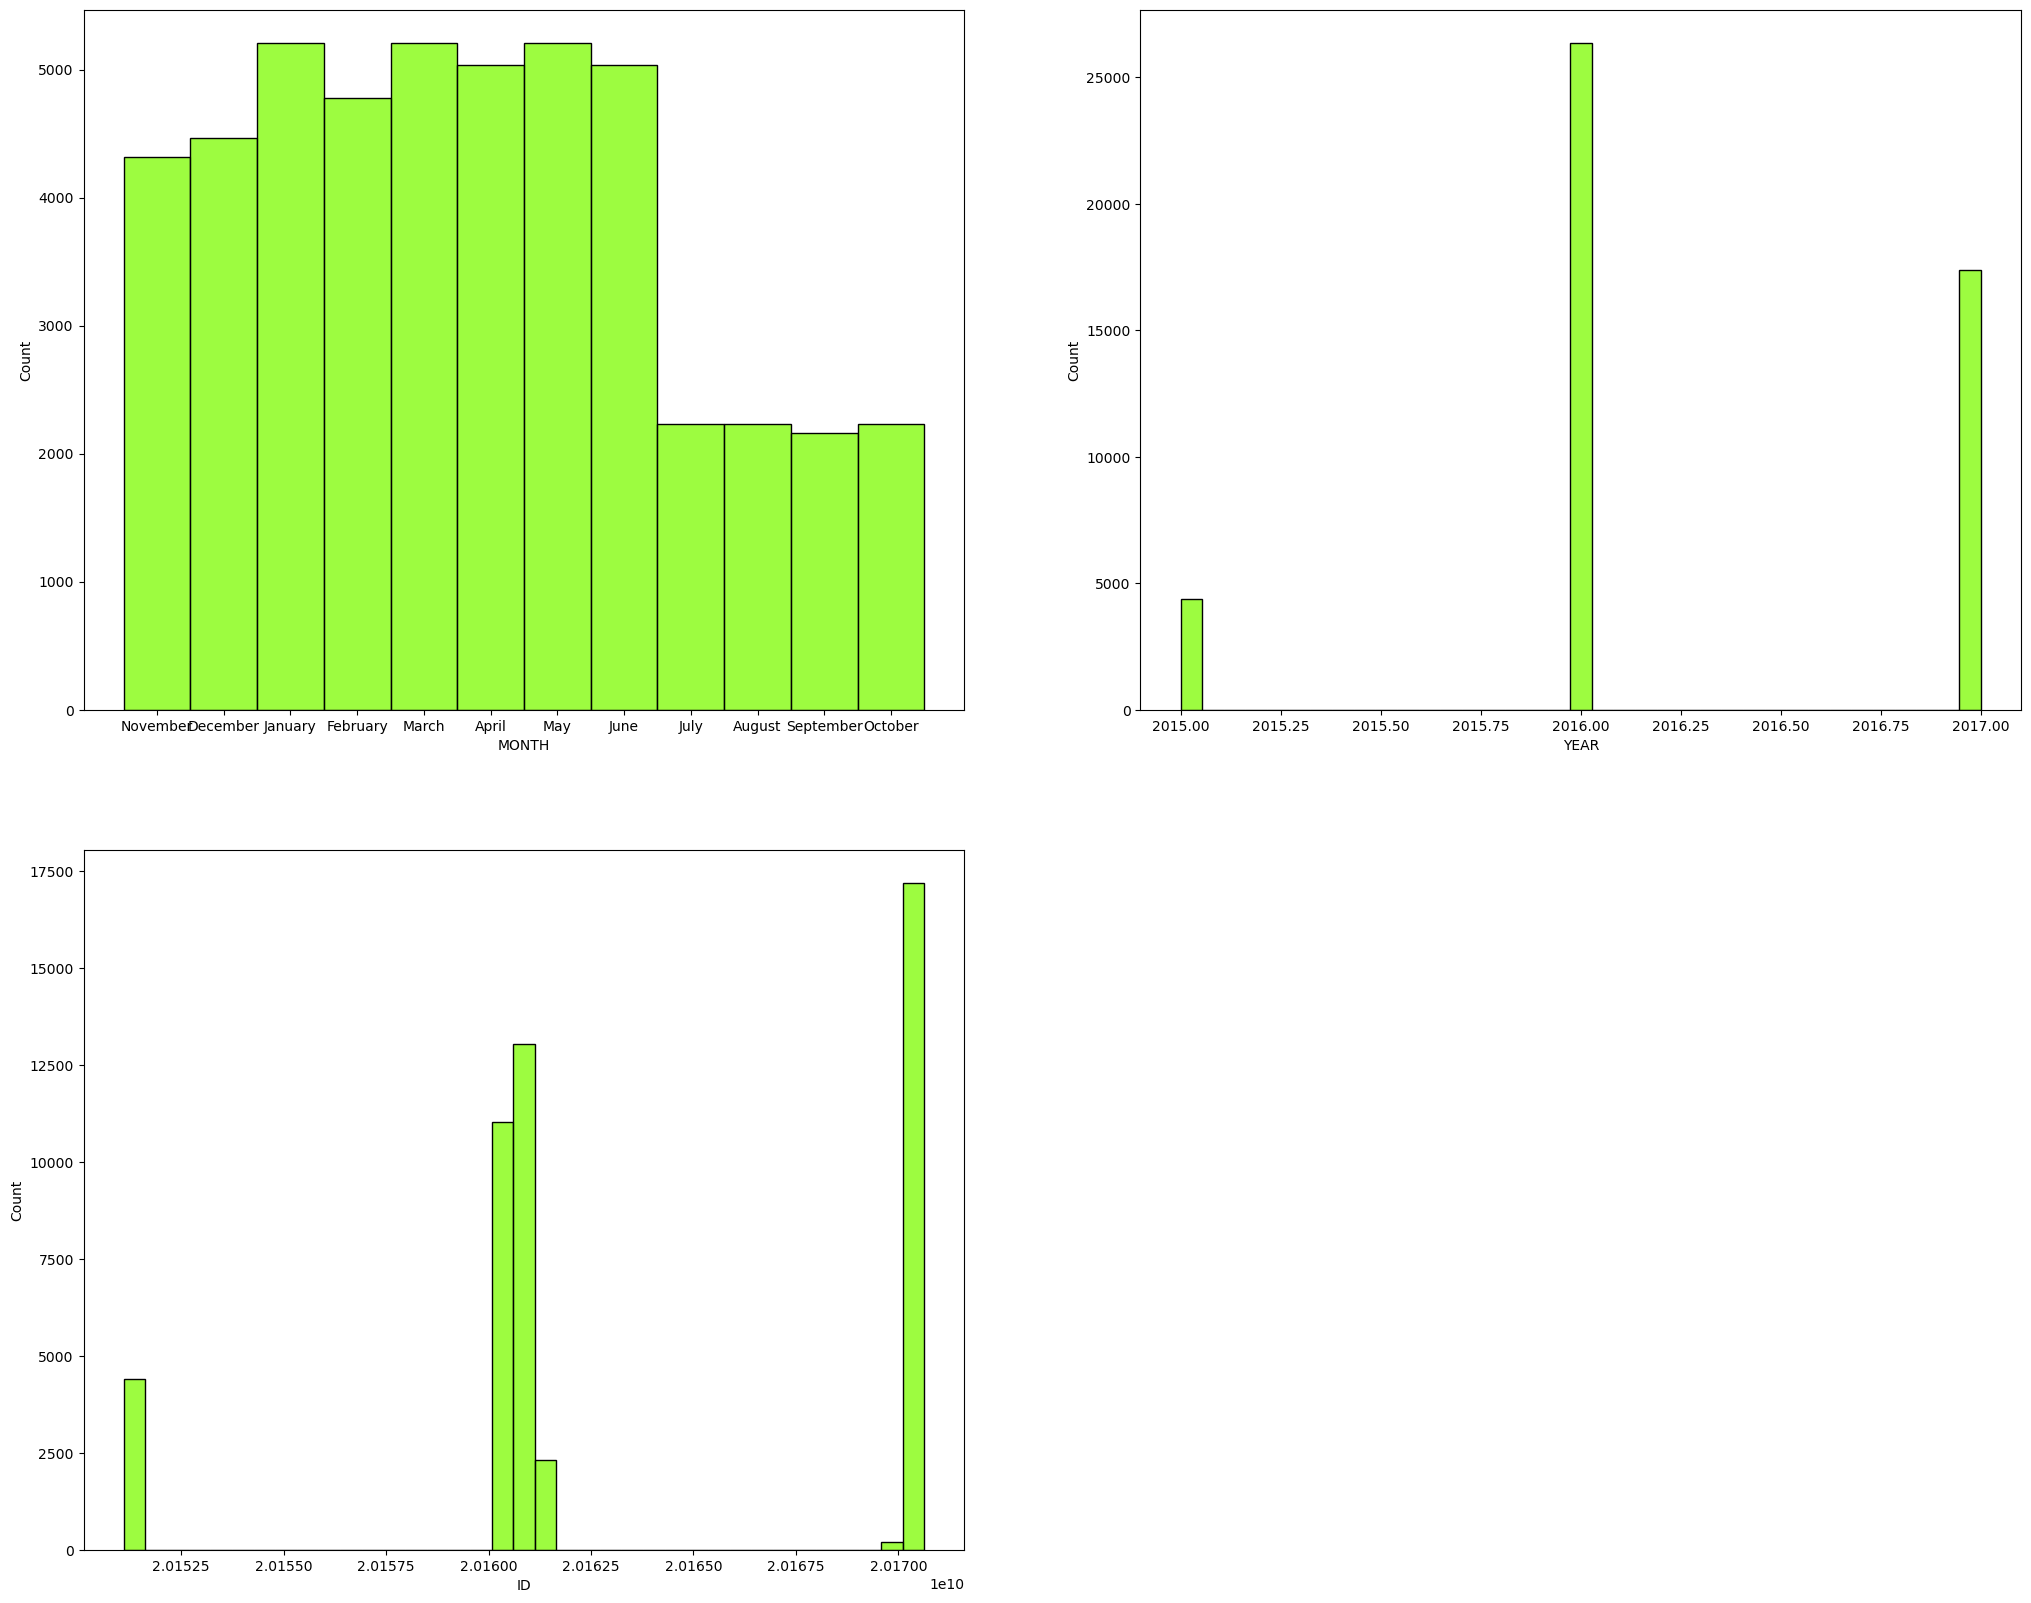

In [18]:
columns = ['MONTH','YEAR','ID']               
# plot histogram for each column in the dataframe

plt.figure(figsize=(25, 20))
for i, column in enumerate(columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=column, color= 'lawngreen')
# display the plot
plt.show()

### Analysis:
#### 1)As more entries for january, march, may months => may be Highest traffic months depends on number of vehicles passed.
#### 2)As more entries for 2016. It will include more passed days.
#### 3)More ID listed is for year 2016. => More persons travelled in this year

In [19]:
junction_entries = df['JUNCTION'].value_counts()
junction_entries

1    14592
2    14592
3    14592
4     4344
Name: JUNCTION, dtype: int64

Text(0, 0.5, 'Junction Enteries')

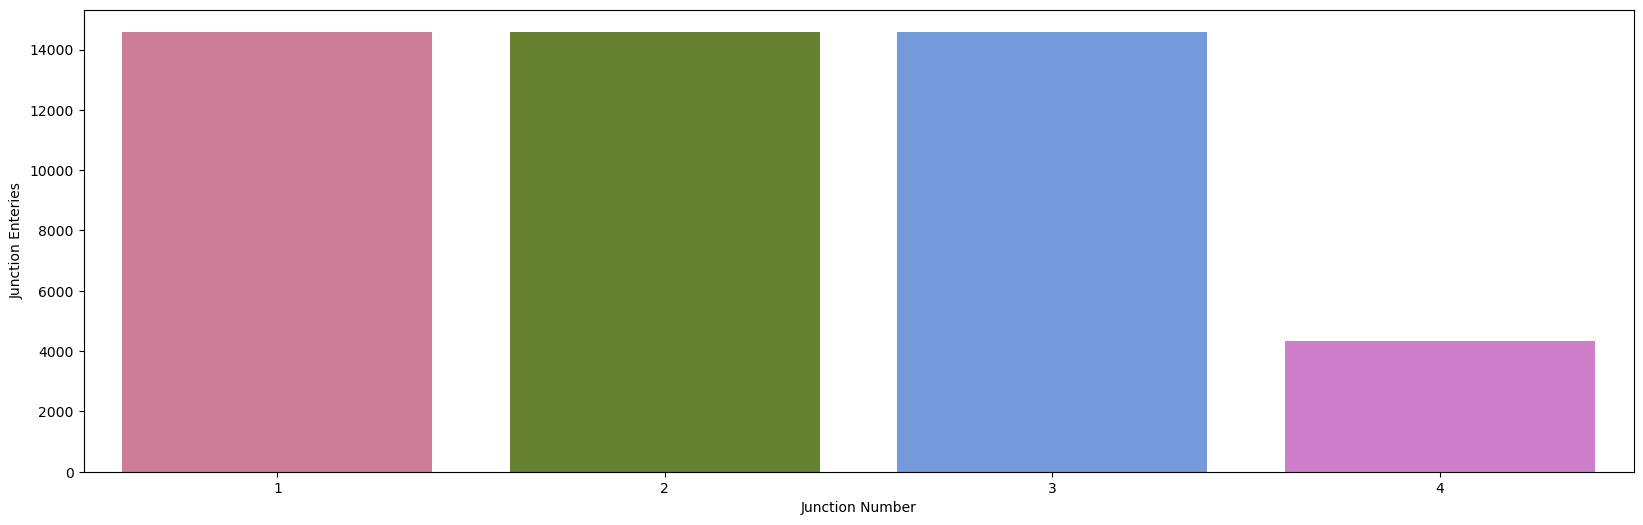

In [20]:
#plotting a graph
plt.figure(figsize=(20, 6))
colors = [ "palevioletred","olivedrab","cornflowerblue","orchid"]
sns.countplot(data = df, x= 'JUNCTION', palette =colors)
plt.xlabel('Junction Number')
plt.ylabel('Junction Enteries')

### Analysis:-
#### 1)The first 3 junctions had same count => Frequenly used by travellers.
#### 2)The 4 th junction has very less entries => may be less used junction for travellers.

In [21]:
vehicles_count = df['VEHICLES'].value_counts()
vehicles_count

8      2325
9      2290
7      2220
6      2206
10     2145
       ... 
129       1
141       1
135       1
143       1
162       1
Name: VEHICLES, Length: 141, dtype: int64

Text(0, 0.5, 'VEHICLES Count')

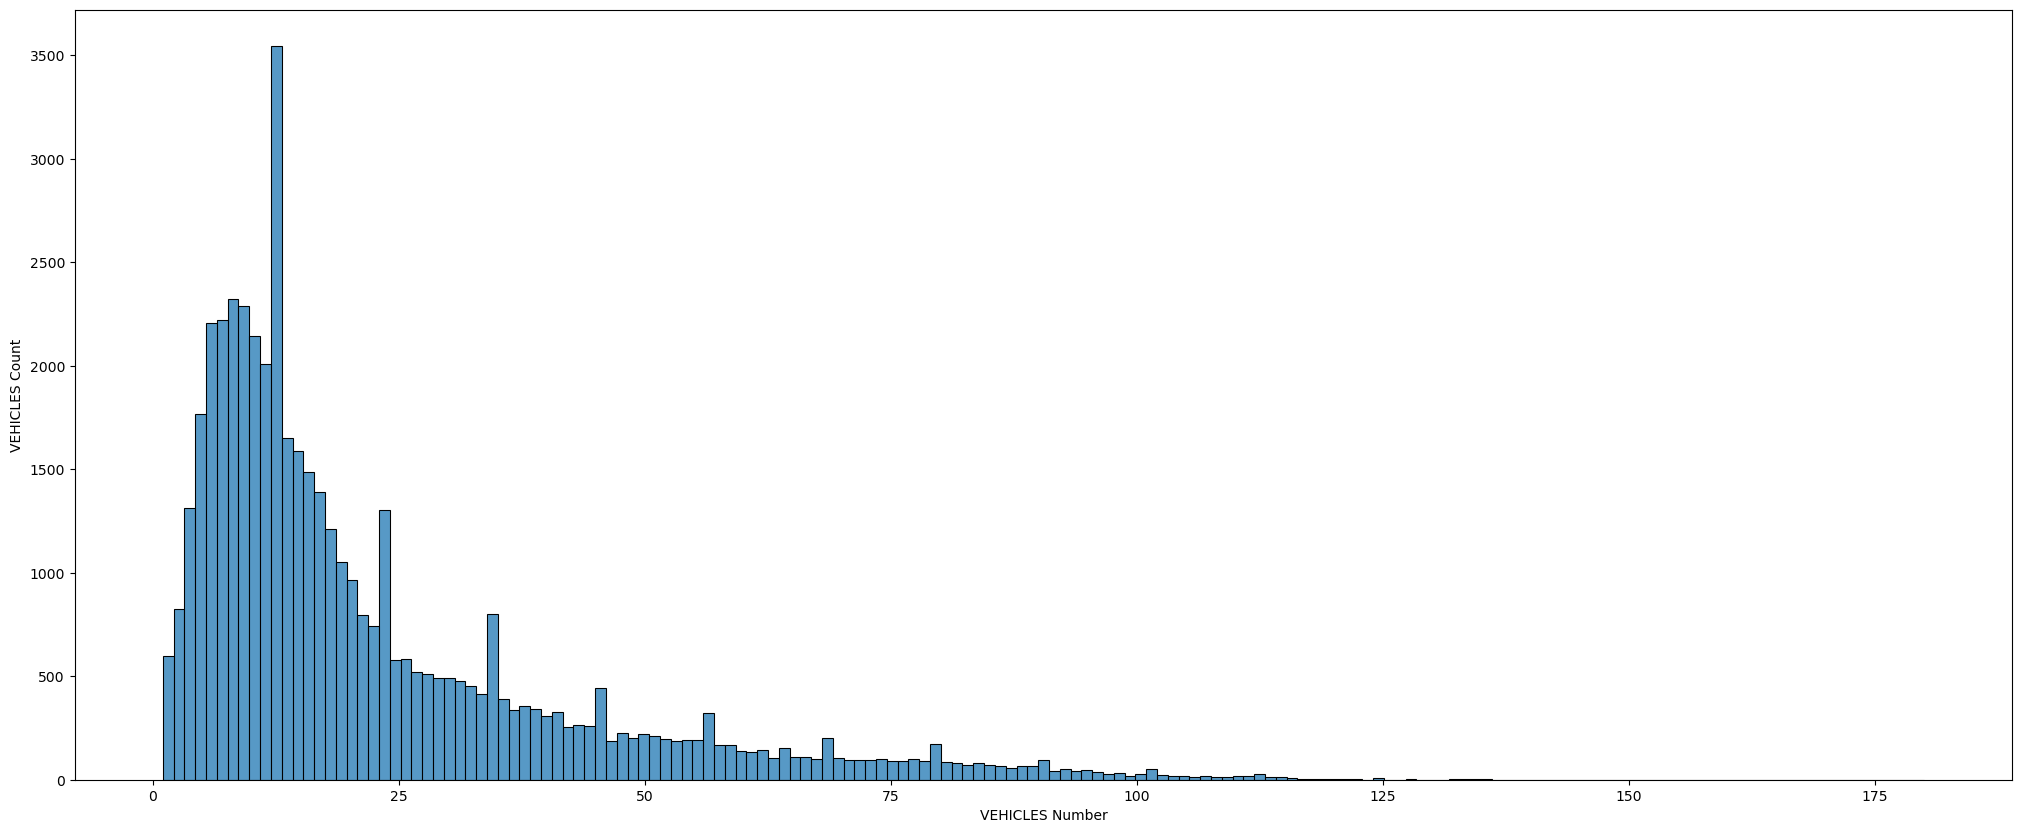

In [22]:
#plotting a graph
plt.figure(figsize=(25, 10))
sns.histplot(data = df, x= 'VEHICLES')
plt.xlabel('VEHICLES Number')
plt.ylabel('VEHICLES Count')

### Analysis-
#### 1)There are more days or say usuall days when traffic flow by vehicles is less than 55.
#### 2)Highly traffic jam occurs when more than 100 vechiles passed in a day. 

In [23]:
year_count= df['YEAR'].value_counts()
year_count

2016    26352
2017    17376
2015     4392
Name: YEAR, dtype: int64

([<matplotlib.patches.Wedge at 0x240d70c7820>,
 [Text(0.3503741610828463, -1.0427070284818702, '2016'),
  Text(-0.041164336874021906, 1.099229501682757, '2017'),
  Text(-1.0930826430807847, 0.12316791544686446, '2015')],
 [Text(0.1911131787724616, -0.5687492882628383, '54.76%'),
  Text(-0.022453274658557402, 0.5995797281905947, '36.11%'),
  Text(-0.5962268962258825, 0.06718249933465334, '9.13%')])

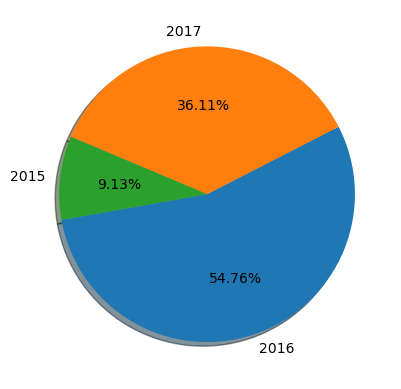

In [24]:
my_labels1 = year_count.index
plt.pie(year_count, labels=my_labels1, shadow = True, startangle = 190,autopct='%1.2f%%')

### Conclusion:
#### 1)2016 - Maximum travelling history found.
#### 2)2015 - Least travelling history found.   

In [25]:
month_count = df['MONTH'].value_counts()
month_count

January      5208
March        5208
May          5208
April        5040
June         5040
February     4776
December     4464
November     4320
July         2232
August       2232
October      2232
September    2160
Name: MONTH, dtype: int64

Text(0, 0.5, 'Monthly Traffic')

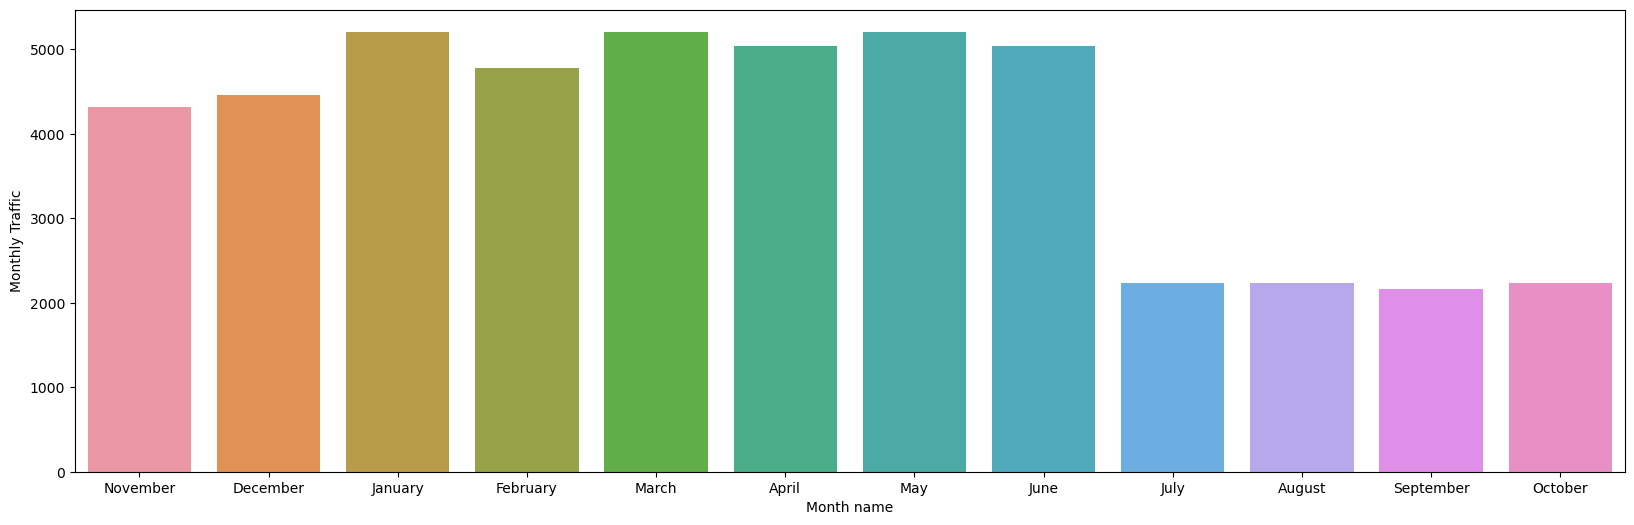

In [26]:
#plotting a graph
plt.figure(figsize=(20, 6))
sns.countplot(data = df, x= 'MONTH')
plt.xlabel('Month name')
plt.ylabel('Monthly Traffic')

### Conclusion:
### 1)January, March, May has most number of travelling history.
### 2)September has least number of travelling history.

In [27]:
day_count= df['DAY'].value_counts()
day_count

Sunday       6888
Monday       6888
Tuesday      6888
Wednesday    6888
Thursday     6888
Friday       6888
Saturday     6792
Name: DAY, dtype: int64

([<matplotlib.patches.Wedge at 0x240d71cfe80>,
 [Text(-0.8925565133669348, -0.642917467834139, 'Sunday'),
  Text(-0.05187922288606523, -1.0987759308579426, 'Monday'),
  Text(0.8280095523938593, -0.7241548046823421, 'Tuesday'),
  Text(1.08207006404563, 0.1977988283491244, 'Wednesday'),
  Text(0.5182776567934378, 0.9702516531646332, 'Thursday'),
  Text(-0.4372406732945093, 1.0093664317862787, 'Friday'),
  Text(-1.0604719320566147, 0.29223155428548636, 'Saturday')],
 [Text(-0.4868490072910553, -0.35068225518225754, '14.31%'),
  Text(-0.02829775793785376, -0.5993323259225141, '14.31%'),
  Text(0.45164157403301414, -0.39499352982673197, '14.31%'),
  Text(0.59022003493398, 0.1078902700086133, '14.31%'),
  Text(0.2826969037055115, 0.5292281744534363, '14.31%'),
  Text(-0.23849491270609594, 0.550563508247061, '14.31%'),
  Text(-0.5784392356672443, 0.15939902961026525, '14.11%')])

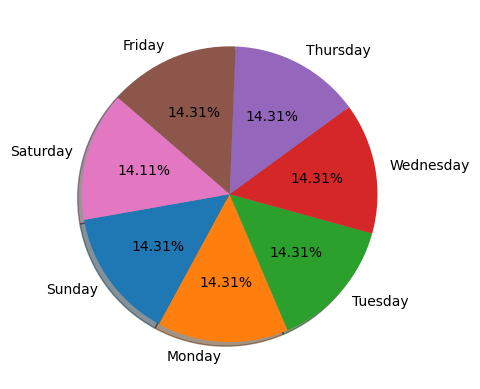

In [28]:
my_labels = day_count.index
plt.pie(day_count, labels=my_labels, shadow = True, startangle = 190,autopct='%1.2f%%')

##### Conclusion:
##### 1)Few Saturday are ommitted

### Q1)What is the sum of vehicles in each junction?

In [29]:
Total_vehicles_in_a_juncton = sqldf('''SELECT JUNCTION, SUM(VEHICLES) AS total_vehicles
FROM df GROUP BY JUNCTION;''')
Total_vehicles_in_a_juncton

JUNCTION  total_vehicles
0         1          657412
1         2          207983
2         3          199823
3         4           31501

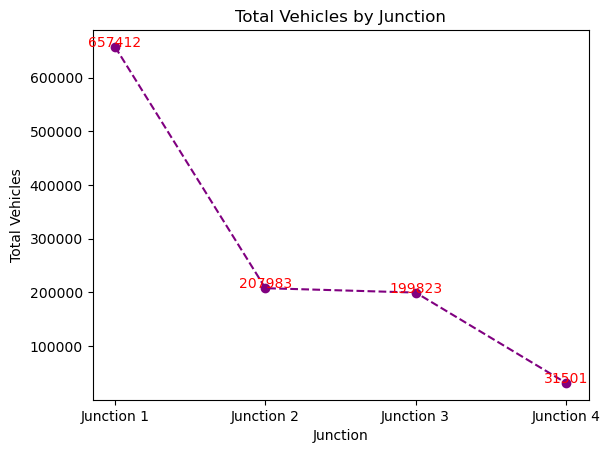

In [30]:
junctions = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
total_vehicles = [657412, 207983, 199823, 31501]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis labels to junctions
ax.set_xticklabels(junctions)
# Plot the data as a dotted graph
ax.plot(junctions, total_vehicles, 'o--', color='purple')
# Add labels to the data points
for i, v in enumerate(total_vehicles):
    ax.text(i, v, str(v), color='red', ha='center')


ax.set_title('Total Vehicles by Junction')
ax.set_xlabel('Junction')
ax.set_ylabel('Total Vehicles')
plt.show()

### Analysis:
#### There are chances that very high number of vechicles crossed from junction 1.

### Q2)What is the average number of vehicles in each junction?

In [31]:
Average_vehicles_in_a_juncton = sqldf('''SELECT JUNCTION, Avg(VEHICLES) AS average_vehicles
FROM df GROUP BY JUNCTION;''')
Average_vehicles_in_a_juncton

JUNCTION  average_vehicles
0         1         45.052906
1         2         14.253221
2         3         13.694010
3         4          7.251611

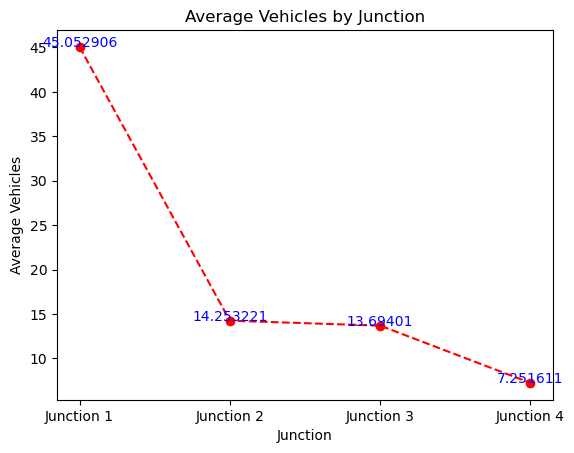

In [32]:
junctions = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
total_vehicles = [45.052906, 14.253221, 13.694010, 7.251611]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis labels to junctions
ax.set_xticklabels(junctions)
# Plot the data as a dotted graph
ax.plot(junctions, total_vehicles, 'o--', color='red')
# Add labels to the data points
for i, v in enumerate(total_vehicles):
    ax.text(i, v, str(v), color='blue', ha='center')


ax.set_title('Average Vehicles by Junction')
ax.set_xlabel('Junction')
ax.set_ylabel('Average Vehicles')
plt.show()

### Analysis:
#### There are chances that many number of vechicles crossed from junction 1 in a year.

### Q3)What is the total number of vehicles for each junction in a year?

In [33]:
yearly_vehicles_for_each_junction = sqldf('''SELECT JUNCTION, YEAR as year, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY JUNCTION, YEAR;''')
yearly_vehicles_for_each_junction

JUNCTION  year  total_vehicles
0         1  2015           30223
1         1  2016          345098
2         1  2017          282091
3         2  2015           12226
4         2  2016          103050
5         2  2017           92707
6         3  2015            8103
7         3  2016          115440
8         3  2017           76280
9         4  2017           31501

Text(0.5, 0, 'year')

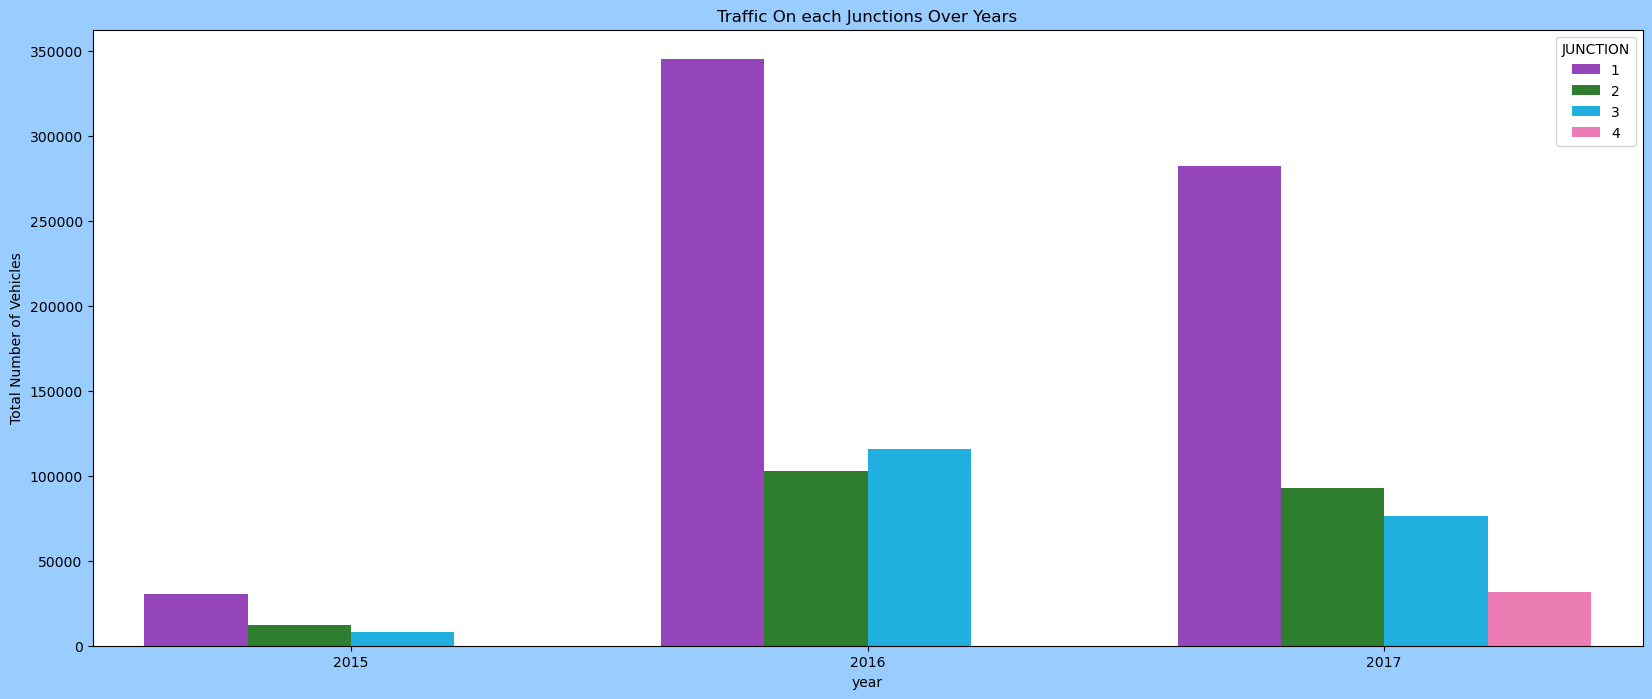

In [34]:
colors = [ "darkorchid","forestgreen","deepskyblue","hotpink"]

plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.barplot(x= "year",y="total_vehicles",data=yearly_vehicles_for_each_junction , hue="JUNCTION", palette=colors)
Time_series.set_title("Traffic On each Junctions Over Years")
Time_series.set_ylabel("Total Number of Vehicles")
Time_series.set_xlabel("year")

### Analysis:
#### 1)In 2015, 2016, there are no vehicles registered or passed from junction 4(NEW_ONE).
#### 2)There is more number of ehicles registered in 2016 or least in 2015.
#### 3)junction 1 is highly traffic flowing junction.

### Q4)What is the total number of vehicles in a year?

In [35]:
yearly_vehicles = sqldf('''SELECT  YEAR as year, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY YEAR;''')
yearly_vehicles

year  total_vehicles
0  2015           50552
1  2016          563588
2  2017          482579

Text(0.5, 1.0, 'yearly Traffic')

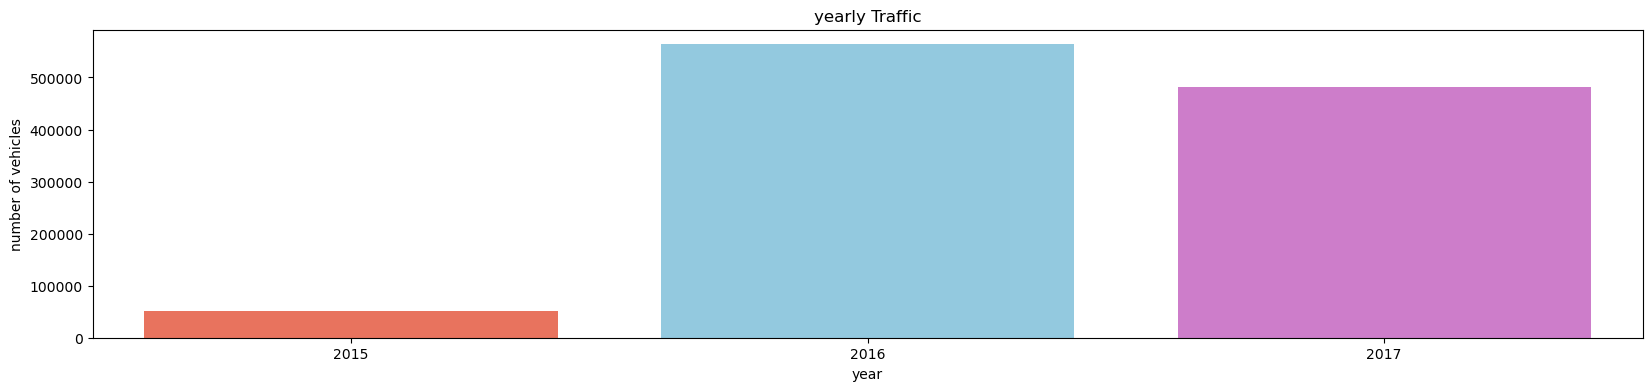

In [36]:
colors = ['tomato','skyblue','orchid']
plt.figure(figsize=(20, 4))
sns.barplot(data = yearly_vehicles, x= 'year', y='total_vehicles', palette = colors)
plt.xlabel('year')
plt.ylabel('number of vehicles')
plt.title('yearly Traffic')

### Analysis:
#### 1)The graph is high fo 2016 then 2017 that means 2016 is highly traffic flowing year.

### Q5)What is the total number of vehicles in each month?

In [37]:
monthly_vehicles = sqldf('''SELECT MONTH as month, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY  MONTH;''')
monthly_vehicles

month  total_vehicles
0       April          123250
1      August           48962
2    December           84655
3    February          109668
4     January          102740
5        July           48742
6        June          131202
7       March          120166
8         May          128291
9    November           84388
10    October           59262
11  September           55393

Text(0.5, 1.0, 'Monthly Traffic')

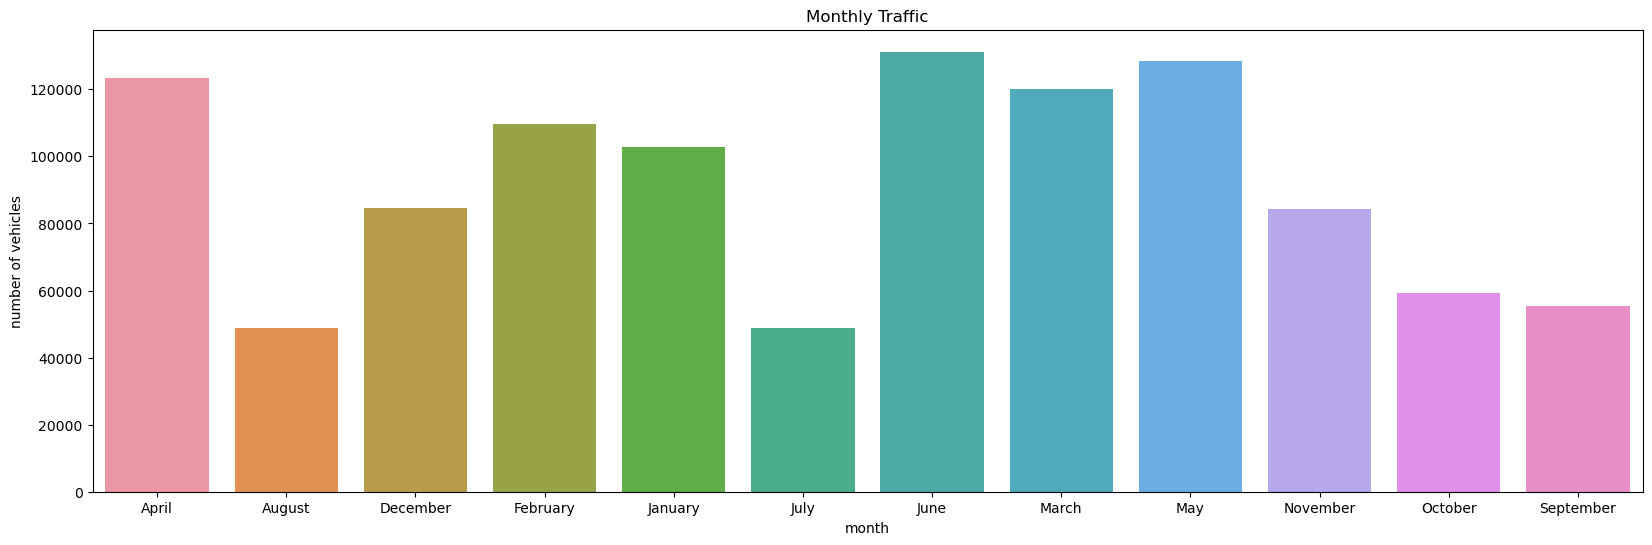

In [38]:
plt.figure(figsize=(20, 6))
sns.barplot(data = monthly_vehicles, x= 'month', y='total_vehicles')
plt.xlabel('month')
plt.ylabel('number of vehicles')
plt.title('Monthly Traffic')

### Analysis:
#### 1)June shows maximum traffic month as many travell between the month of june to may.

### Q6)What is the total number of vehicles for each junction in each month?

In [39]:
monthly_vehicles_for_each_juncton = sqldf('''SELECT JUNCTION, MONTH as month, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY JUNCTION, MONTH;''')
monthly_vehicles_for_each_juncton

JUNCTION      month  total_vehicles
0          1      April           67486
1          1     August           31185
2          1   December           54899
3          1   February           62929
4          1    January           61379
5          1       July           29111
6          1       June           79314
7          1      March           69326
8          1        May           77227
9          1   November           52958
10         1    October           37224
11         1  September           34374
12         2      April           24247
13         2     August            8237
14         2   December           16183
15         2   February           19881
16         2    January           16618
17         2       July            8582
18         2       June           27064
19         2      March           23931
20         2        May           27326
21         2   November           16466
22         2    October           10383
23         2  September            9065
24         3      April           27063
25         3     August            9540
26         3   December           13573
27         3   February           21294
28         3    January           19165
29         3       July           11049
30         3       June           18727
31         3      March           21978
32         3        May           18861
33         3   November           14964
34         3    October           11655
35         3  September           11954
36         4      April            4454
37         4   February            5564
38         4    January            5578
39         4       June            6097
40         4      March            4931
41         4        May            4877

Text(0.5, 0, 'year')

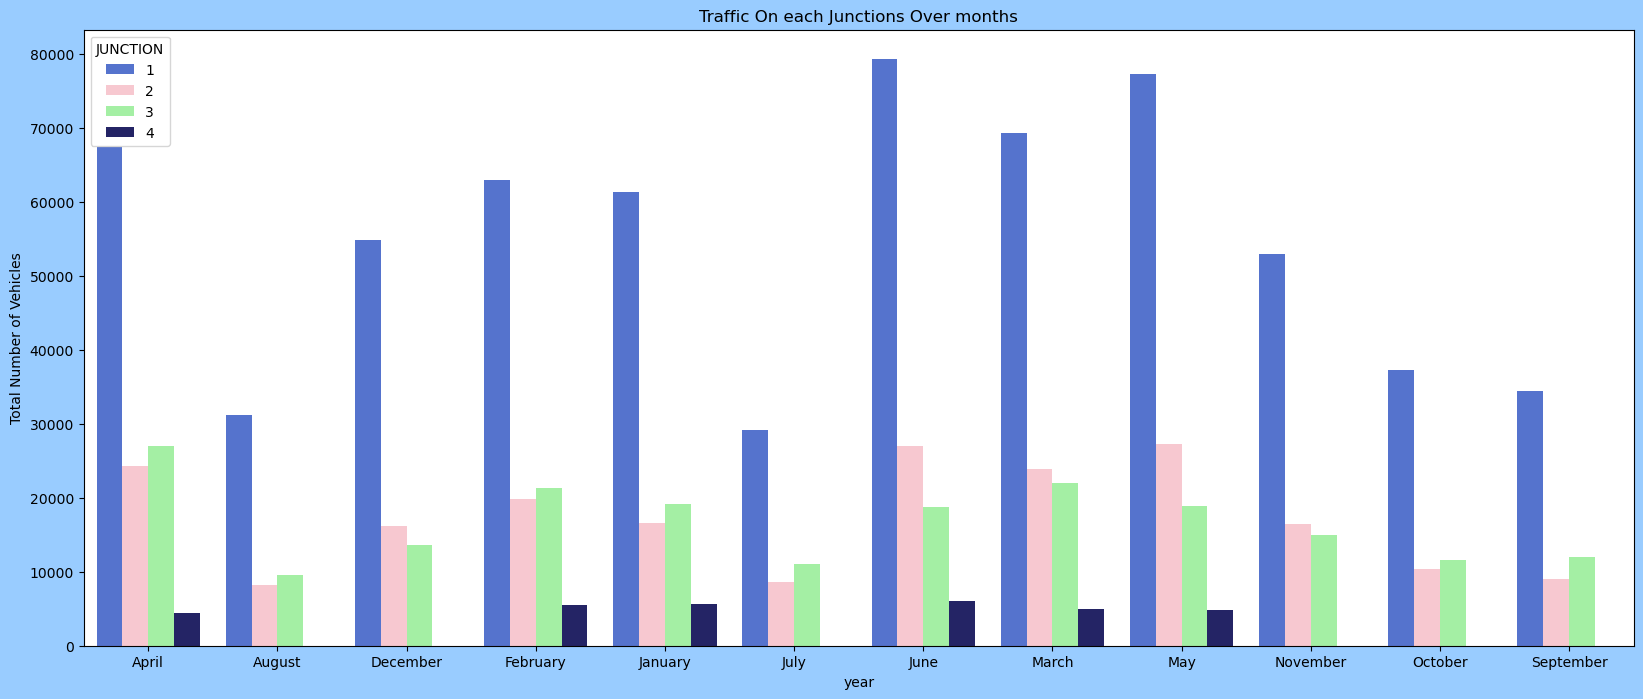

In [40]:
colors = [ "royalblue","pink","palegreen","midnightblue"]

plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.barplot(x= "month",y="total_vehicles",data=monthly_vehicles_for_each_juncton , hue="JUNCTION", palette=colors)
Time_series.set_title("Traffic On each Junctions Over months")
Time_series.set_ylabel("Total Number of Vehicles")
Time_series.set_xlabel("year")

### Analysis:
#### 1)Junction 1 is more used to travel also june to march more travelling is found in these months.

### Q7)What is the total number of vehicles for each junction in each day?

In [41]:
Daywise_vehicles_for_each_juncton = sqldf('''SELECT JUNCTION, DAY as day, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY JUNCTION, DAY;''')
Daywise_vehicles_for_each_juncton

JUNCTION        day  total_vehicles
0          1     Friday           98224
1          1     Monday          103156
2          1   Saturday           70407
3          1     Sunday           67439
4          1   Thursday          104994
5          1    Tuesday          106991
6          1  Wednesday          106201
7          2     Friday           31200
8          2     Monday           31798
9          2   Saturday           21492
10         2     Sunday           21181
11         2   Thursday           33463
12         2    Tuesday           34571
13         2  Wednesday           34278
14         3     Friday           29965
15         3     Monday           28517
16         3   Saturday           30128
17         3     Sunday           25694
18         3   Thursday           29857
19         3    Tuesday           27670
20         3  Wednesday           27992
21         4     Friday            4560
22         4     Monday            4661
23         4   Saturday            3928
24         4     Sunday            3710
25         4   Thursday            4939
26         4    Tuesday            4943
27         4  Wednesday            4760

Text(0.5, 0, 'day')

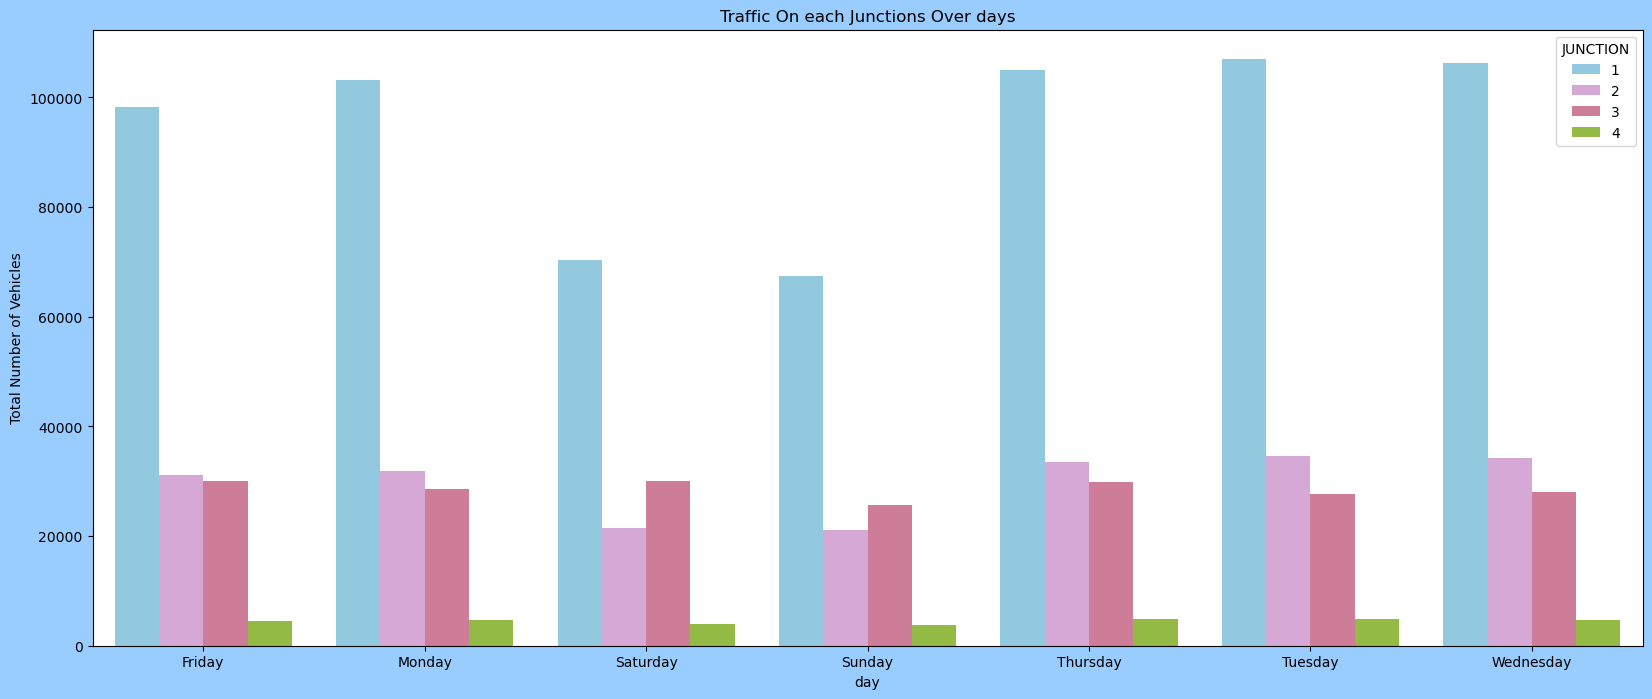

In [42]:
colors = [ "skyblue","plum","palevioletred","yellowgreen"]

plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.barplot(x= "day",y="total_vehicles", data=Daywise_vehicles_for_each_juncton , hue="JUNCTION", palette=colors)
Time_series.set_title("Traffic On each Junctions Over days")
Time_series.set_ylabel("Total Number of Vehicles")
Time_series.set_xlabel("day")

### Analysis:
#### 1)Tuesday, thursday, wednesday, monday these days people travel more may be working-days. 

### Q8)What is the total number of vehicles in a day?

In [43]:
day_wise_traffic = sqldf('''SELECT  DAY as day, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY DAY;''')
day_wise_traffic 

day  total_vehicles
0     Friday          163949
1     Monday          168132
2   Saturday          125955
3     Sunday          118024
4   Thursday          173253
5    Tuesday          174175
6  Wednesday          173231

Text(0.5, 1.0, 'Day wise Traffic')

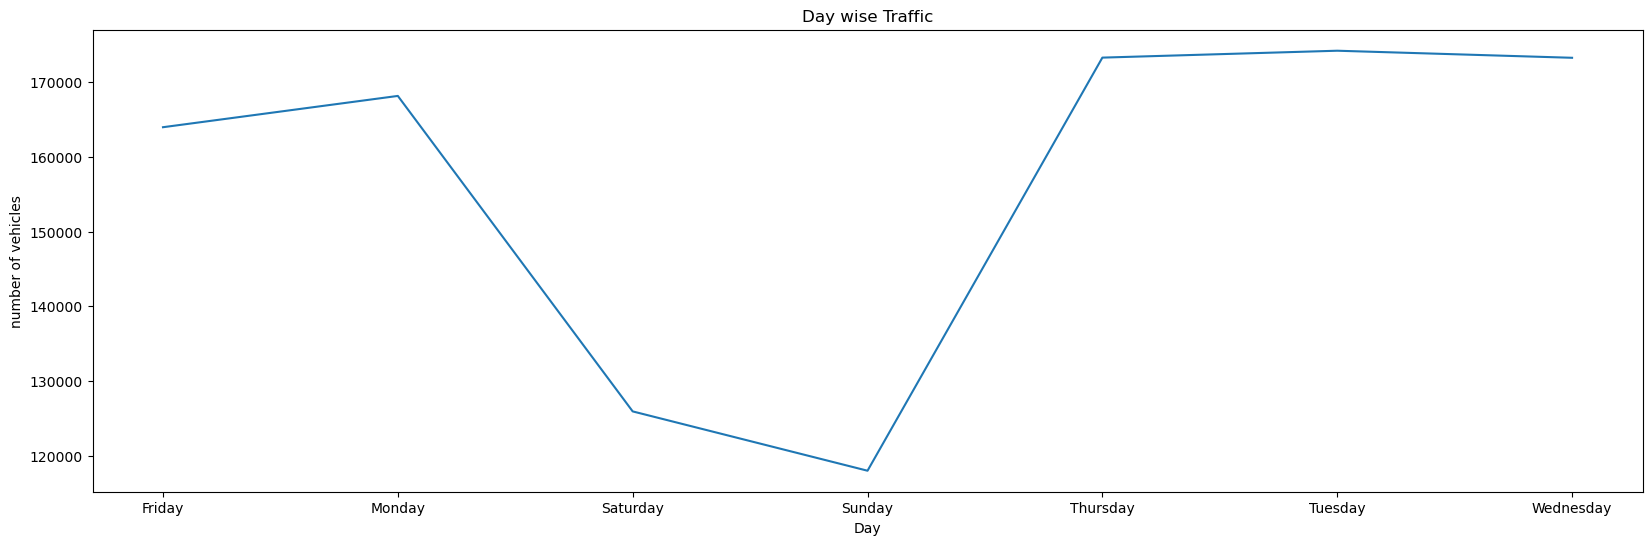

In [44]:
plt.figure(figsize=(20, 6))
sns.lineplot(data = day_wise_traffic, x= 'day', y='total_vehicles')
plt.xlabel('Day')
plt.ylabel('number of vehicles')
plt.title('Day wise Traffic')

### Analysis:
#### 1)The graph is lower on sunday then saturday i.e it is non working days..people used to travel monday to friday as traffic day will be.

### Q9)What is the total number of vehicles for each junction in a day event?

In [45]:
Eventwise_vehicles_for_each_juncton = sqldf('''SELECT JUNCTION, DAY_EVENTS as Events, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY JUNCTION, DAY_EVENTS;''')
Eventwise_vehicles_for_each_juncton

JUNCTION         Events  total_vehicles
0          1  Early Morning           64040
1          1        Evening          132531
2          1     Late Night           90126
3          1        Morning          107892
4          1          Night          130715
5          1           Noon          132108
6          2  Early Morning           23435
7          2        Evening           41093
8          2     Late Night           32975
9          2        Morning           30401
10         2          Night           41521
11         2           Noon           38558
12         3  Early Morning           15475
13         3        Evening           43072
14         3     Late Night           23629
15         3        Morning           32029
16         3          Night           43848
17         3           Noon           41770
18         4  Early Morning            2974
19         4        Evening            6406
20         4     Late Night            3937
21         4        Morning            5131
22         4          Night            6251
23         4           Noon            6802

Text(0.5, 0, 'Events')

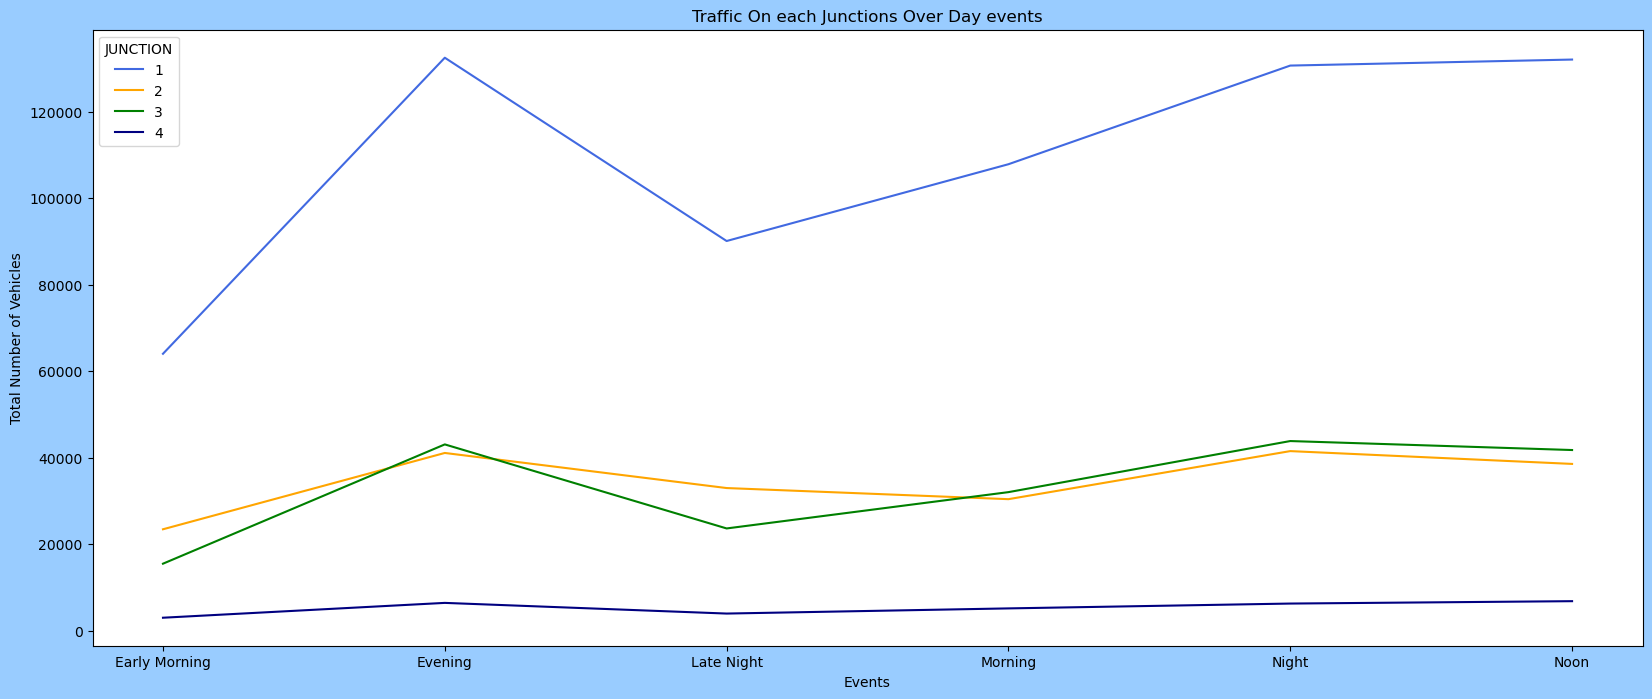

In [46]:
colors = [ "royalblue","orange","green","navy"]

plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x= "Events",y="total_vehicles",data=Eventwise_vehicles_for_each_juncton , hue="JUNCTION", palette=colors)
Time_series.set_title("Traffic On each Junctions Over Day events")
Time_series.set_ylabel("Total Number of Vehicles")
Time_series.set_xlabel("Events")

### Analysis:
#### 1)From junction 1 most people travel and maximum in noon to night andless in late night .
#### 2)From junction 2,3 people travel  maximum in noon to night.
#### 3)From junction 4 less people travel and maximum in evening.

### Q10)What is the total number of vehicles  in a day event?

In [47]:
Part_of_the_day_traffic = sqldf('''SELECT  DAY_EVENTS as Events, SUM(VEHICLES) AS total_vehicles 
FROM df GROUP BY DAY_EVENTS;''')
Part_of_the_day_traffic

Events  total_vehicles
0  Early Morning          105924
1        Evening          223102
2     Late Night          150667
3        Morning          175453
4          Night          222335
5           Noon          219238

Text(0.5, 0, 'Events')

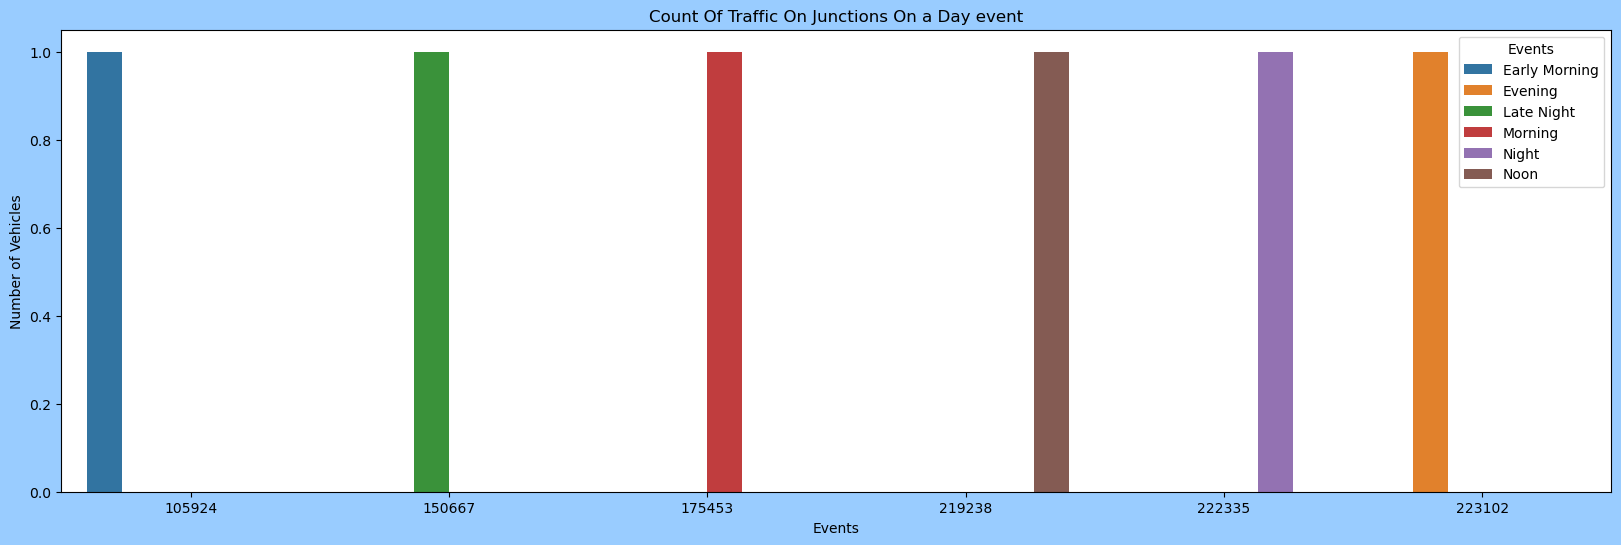

In [48]:
plt.figure(figsize=(20,6),facecolor="#99ccff")

count = sns.countplot(data=Part_of_the_day_traffic, hue ='Events', x="total_vehicles")
count.set_title("Count Of Traffic On Junctions On a Day event")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Events")

### Analysis:
#### 1)In a day most people like to travel in noon to night.

### Q11)What is Range of id for each junction?

In [49]:
Range_id_for_each_junction = sqldf('''SELECT JUNCTION, MAX(ID) AS max_id, MIN(ID) AS min_id
FROM df GROUP BY jUNCTION;''')
Range_id_for_each_junction 

JUNCTION       max_id       min_id
0         1  20170630231  20151101001
1         2  20170630232  20151101002
2         3  20170630233  20151101003
3         4  20170630234  20170101004

### Note:
#### Junction1 - id goes 2015....01 to 2017.....31
#### Junction2 - id goes 2015....02 to 2017.....32
#### Junction3 - id goes 2015....03 to 2017.....33
#### Junction4 - id goes 2015....01 to 2017.....34

### Data exploration
##### Pharsing dates
##### Ploting timeseris
##### Feature engineering for EDA

Text(0.5, 0, 'Date')

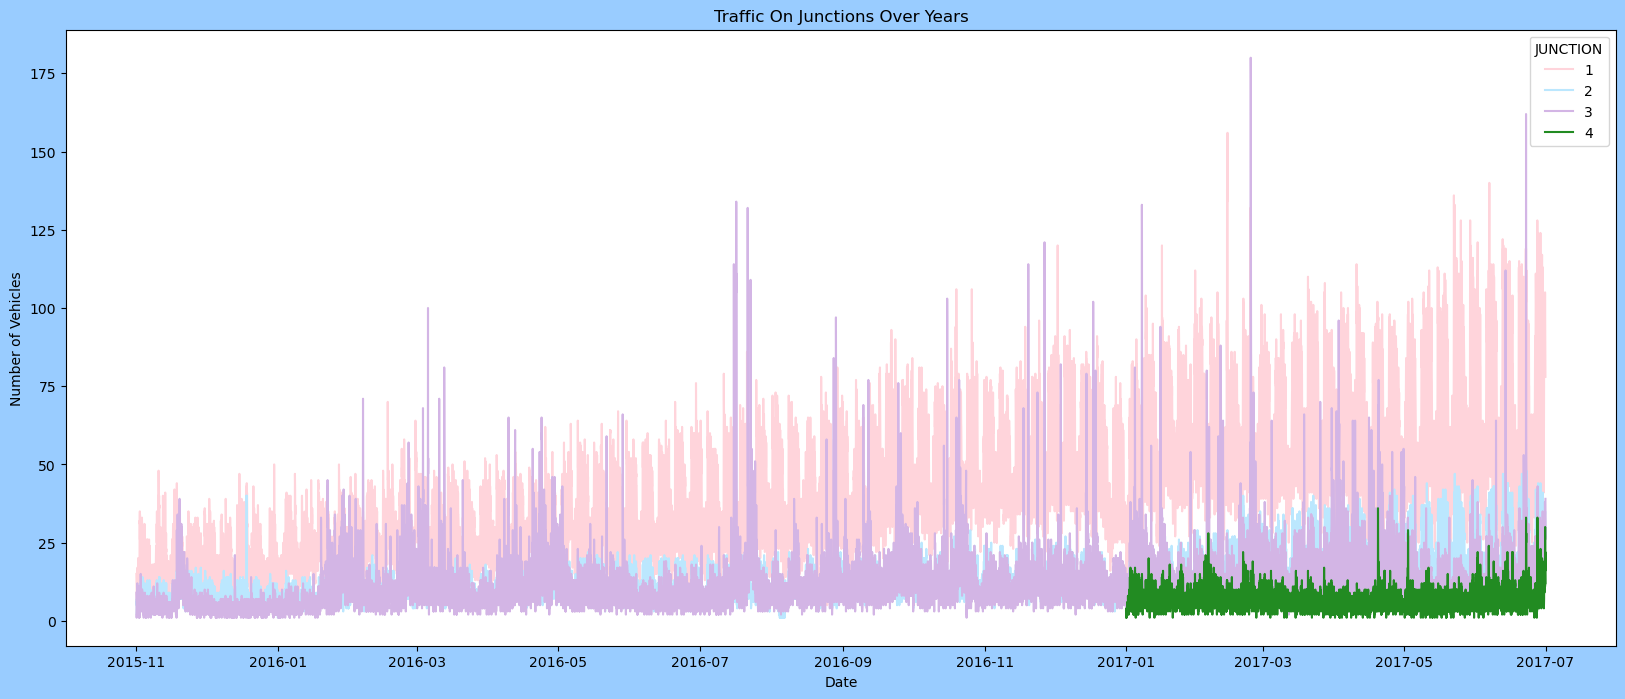

In [50]:
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","forestgreen"]

plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=df['DATETIME'],y="VEHICLES",data=df, hue="JUNCTION", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

### Analysis:
#### It can be seen here that the first junction is visibly having an upward trend.
#### The data for the fourth junction is starting only after 2017

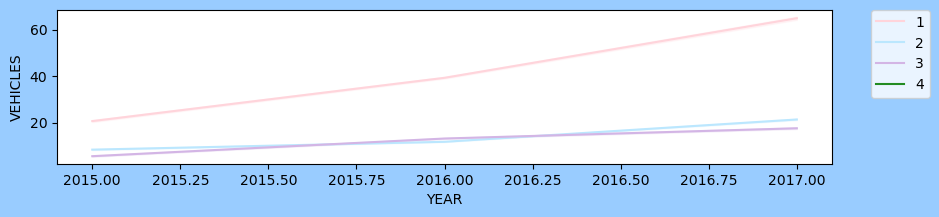

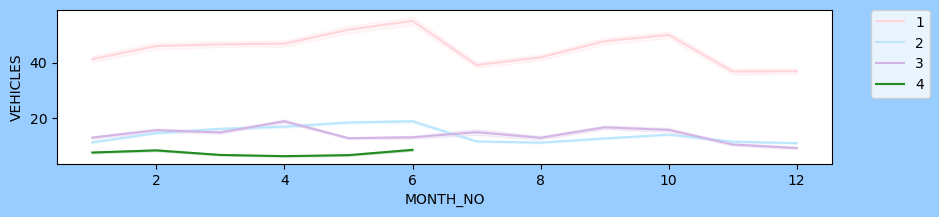

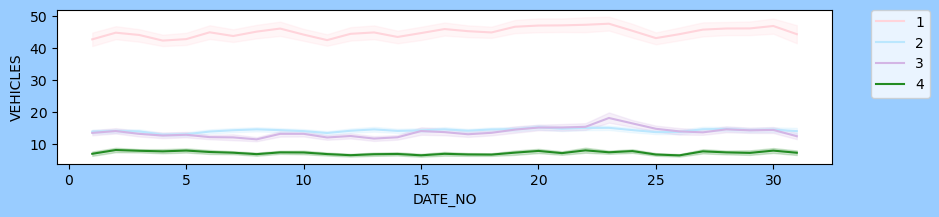

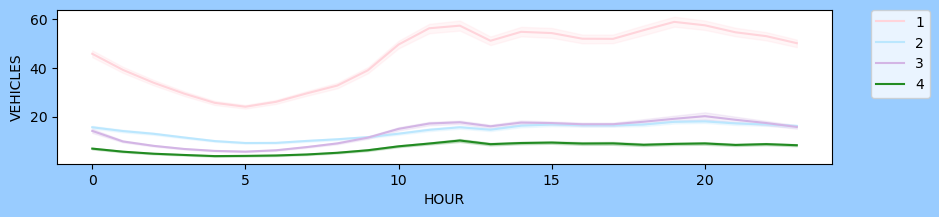

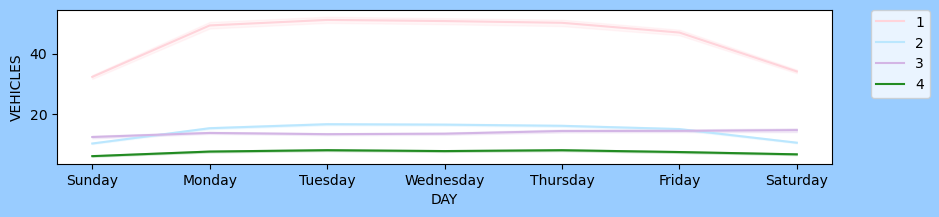

In [51]:
#Let's plot the Timeseries
new_features = [ "YEAR","MONTH_NO", "DATE_NO", "HOUR", "DAY"]

for i in new_features:
    plt.figure(figsize=(10, 2),facecolor="#99ccff")
    ax=sns.lineplot(x=df[i], y="VEHICLES",data=df, hue="JUNCTION", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Analysis:

#### 1)Yearly, there has been an upward trend for all junctions except for the fourth junction. 
#### 2)We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.
#### Monthly, throughout all the dates there is a good consistency in data.
#### 3)For a day, we can see that are peaks during morning and evening times and a decline during late night hours. This is as per expectation.
#### 4)For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

Text(0.5, 0, 'Date')

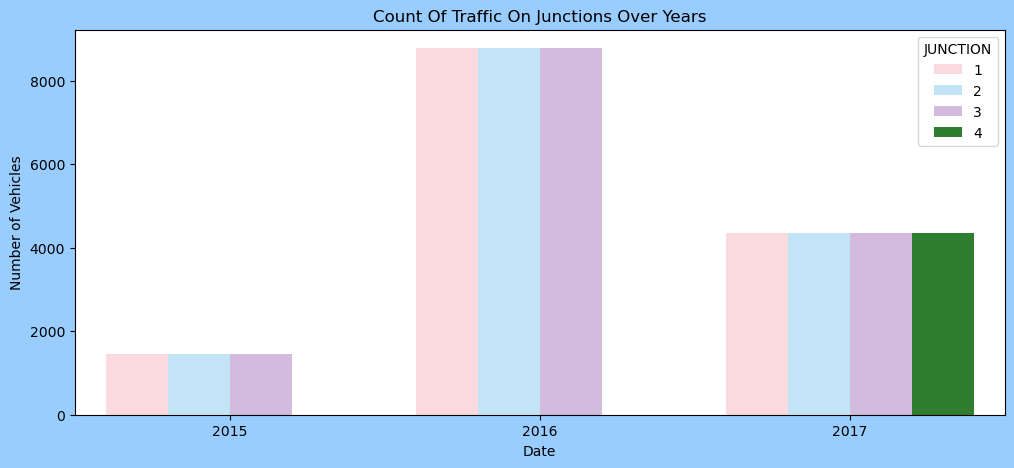

In [52]:
plt.figure(figsize=(12,5),facecolor="#99ccff")

count = sns.countplot(data=df, x =df["YEAR"], hue="JUNCTION", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

### Conclusion:
#### The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. 
#### However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month.

<Axes: >

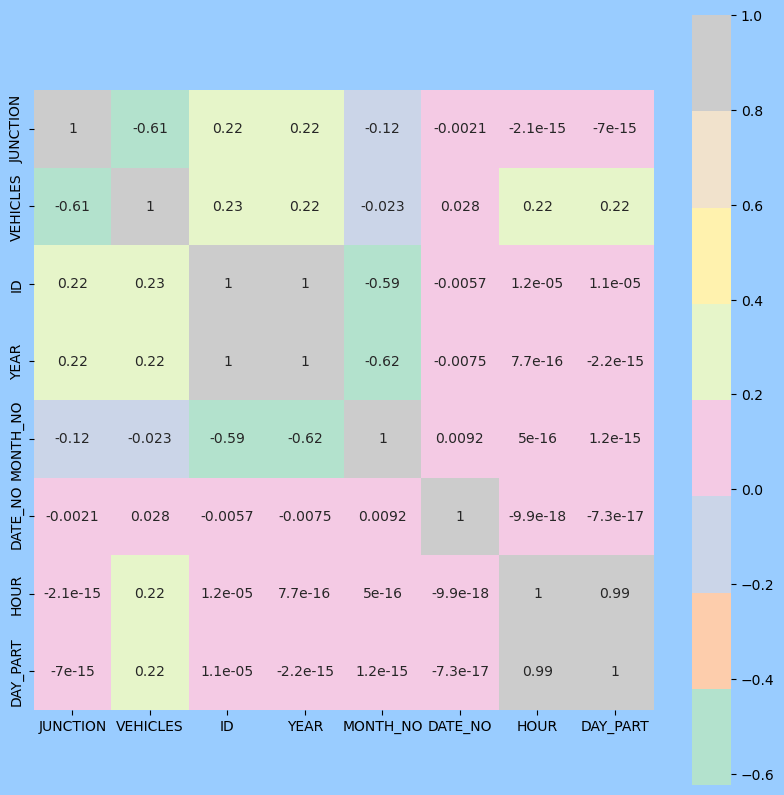

In [53]:
# Select only numeric dtypes
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corrmat = numeric_df.corr()

# Plot heatmap
plt.subplots(figsize=(10,10),facecolor="#99ccff")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

#### The highest correlation is certainly with the pre-existing feature.


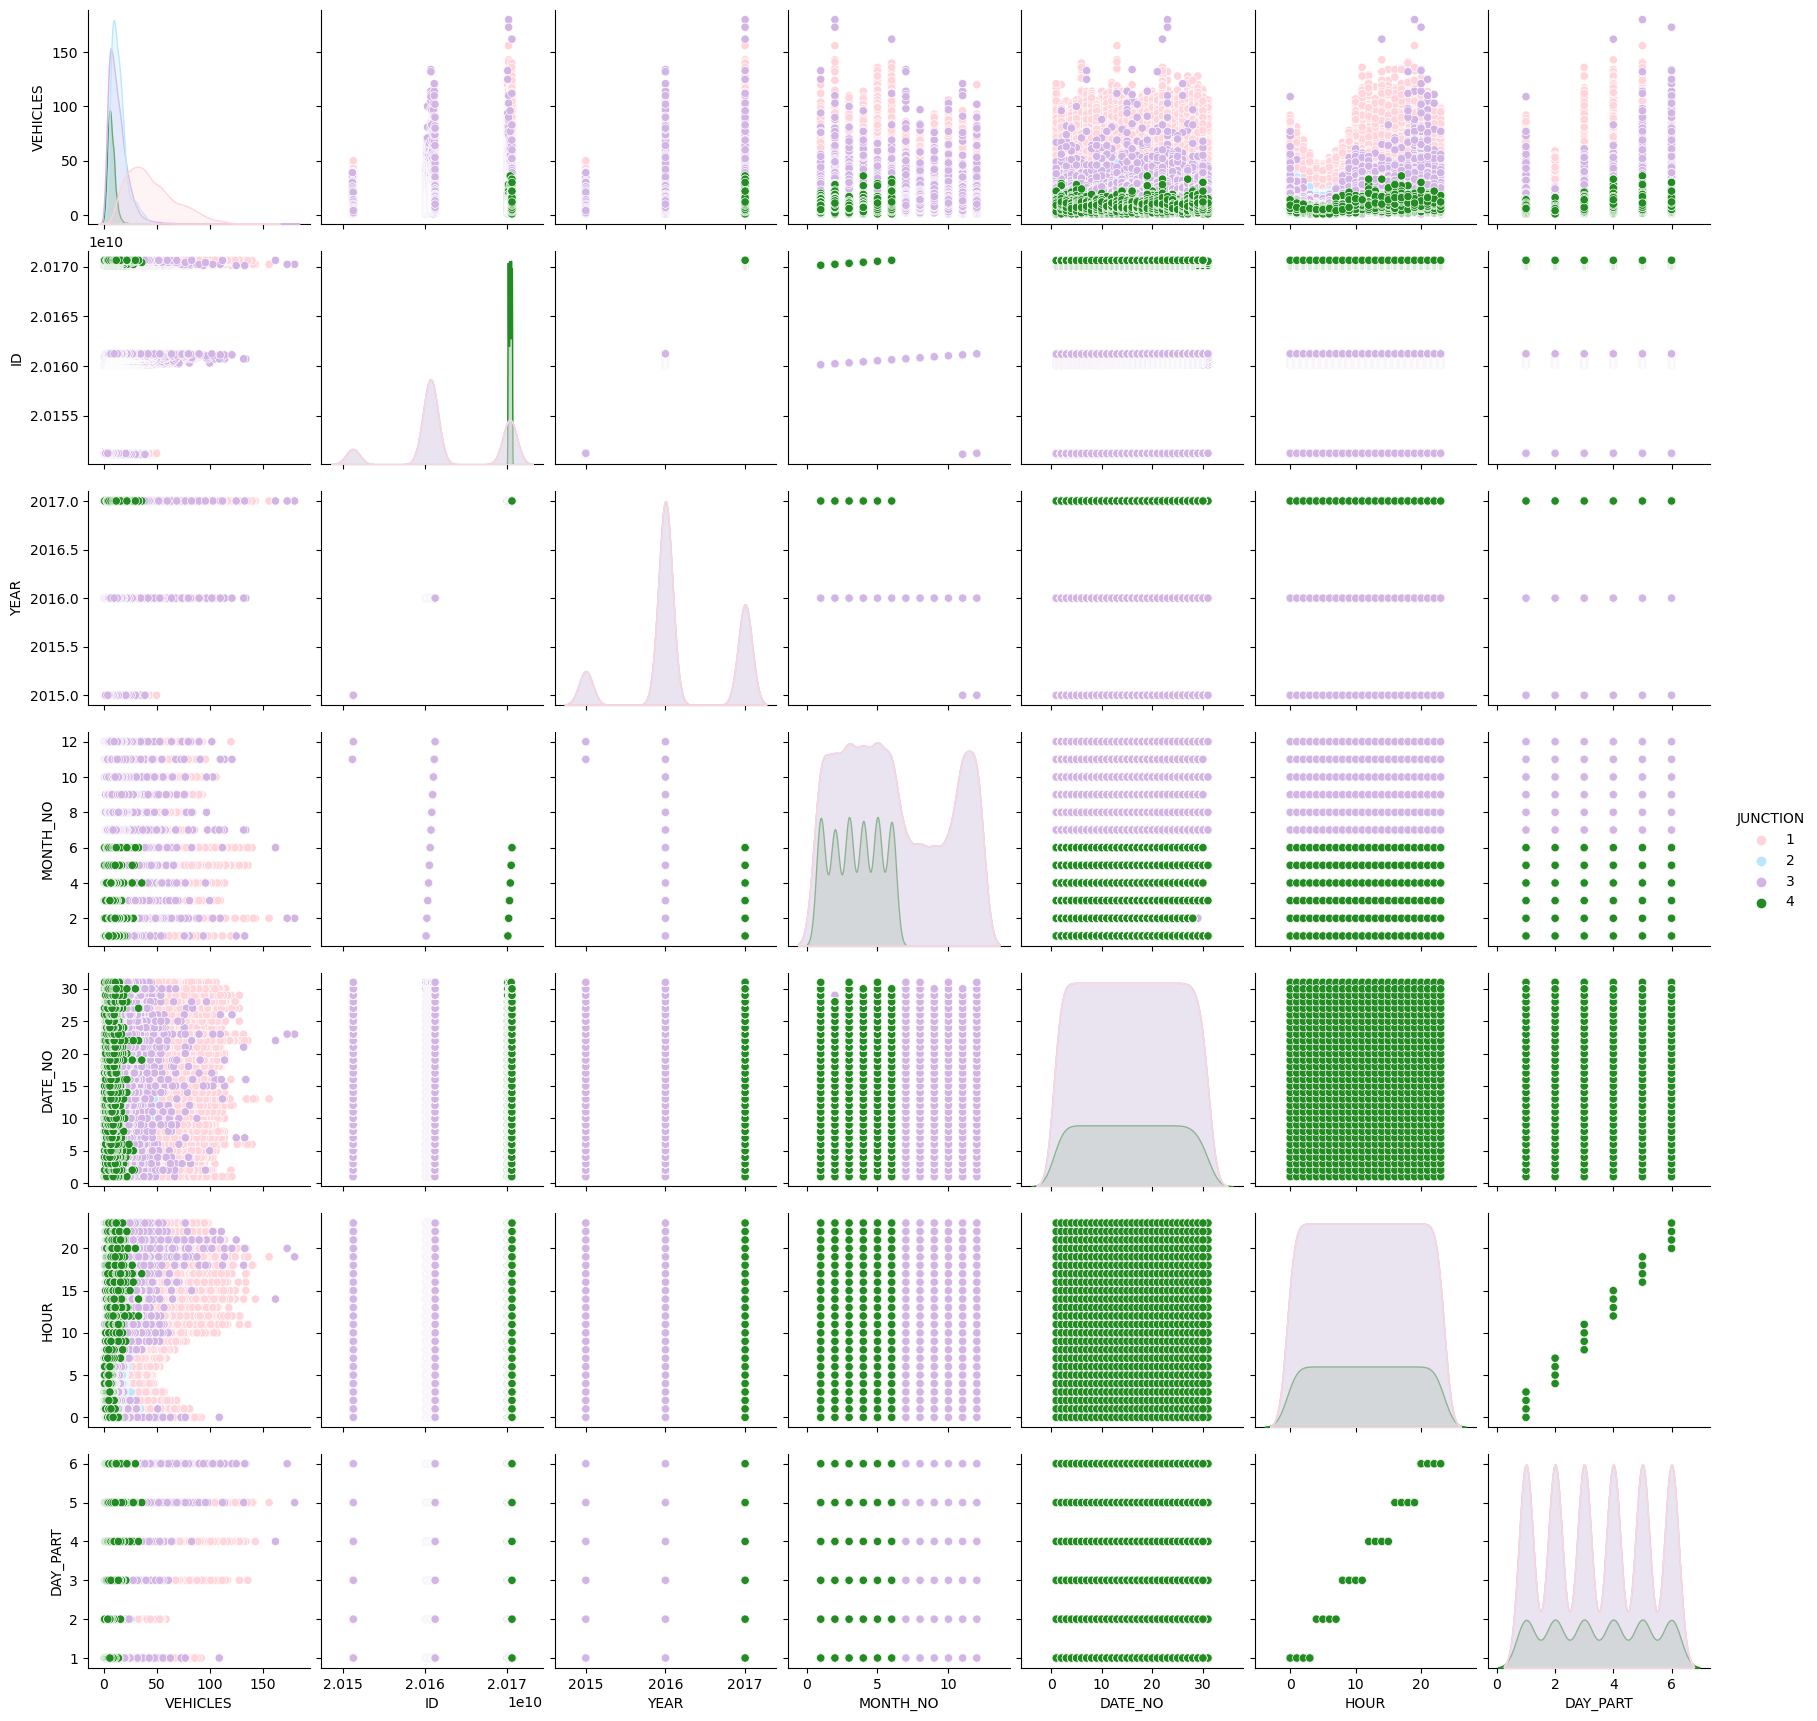

In [54]:
sns.pairplot(data=df, hue= "JUNCTION",palette=colors)

### Conclusion: EDA

#### 1)The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
#### 2)The yearly trend for Junctions one, two and three have diffrent slopes.


## Data Transformation And Preprocessing

##### a)Creating different frames for each Junction and plotting them
##### b)Transforming the series and plotting them
##### c)Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
##### d)Creating test and train sets

In [55]:
data =df.copy()
data = data.drop(["ID","YEAR","DATE_NO","HOUR","DAY_PART","MONTH_NO"], axis=1)
#Pivoting data fron junction
df_J = data.pivot(columns="JUNCTION", index="DATETIME")
df_J.describe()

VEHICLES                                         
JUNCTION             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

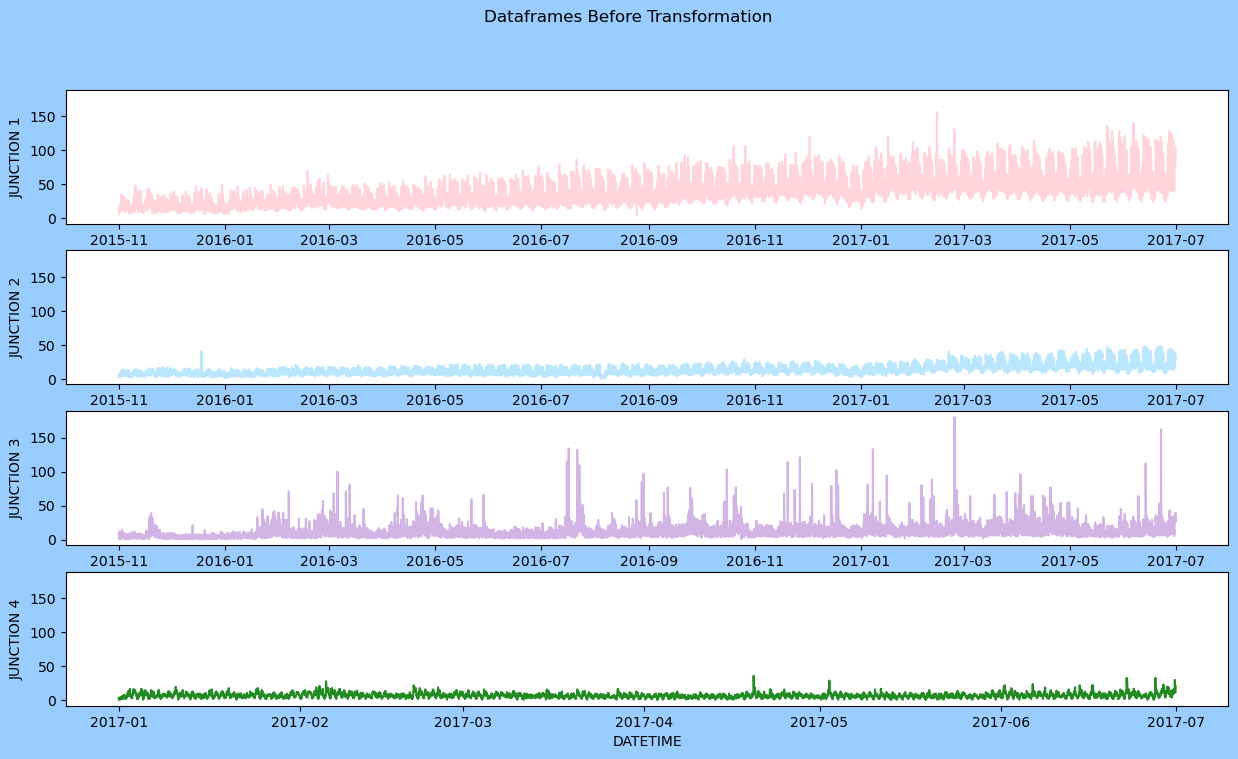

In [56]:
#Creating new sets
df_1 = df_J[[('VEHICLES', 1)]]
df_2 = df_J[[('VEHICLES', 2)]]
df_3 = df_J[[('VEHICLES', 3)]]
df_4 = df_J[[('VEHICLES', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2, df_3, df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="JUNCTION 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="JUNCTION 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="JUNCTION 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="JUNCTION 4")
    #Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.VEHICLES, df_2.VEHICLES, df_3.VEHICLES, df_4.VEHICLES,"Dataframes Before Transformation")

#### Note: In the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality.

## Steps for Transforming:
##### Normalizing
##### Differencing

In [57]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

#### In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:

#### For Junction one, I will be taking a difference of weekly values.
#### For junction two, The difference of consecutive days is a better choice
#### For Junctions three and four, the difference of the hourly values will serve the purpose.

In [58]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "VEHICLES")
Diff_1 = Difference(df_N1, col="VEHICLES", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "VEHICLES")
Diff_2 = Difference(df_N2, col="VEHICLES", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "VEHICLES")
Diff_3 = Difference(df_N3, col="VEHICLES", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "VEHICLES")
Diff_4 = Difference(df_N4, col="VEHICLES", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

## Plots of Transformed Dataframe

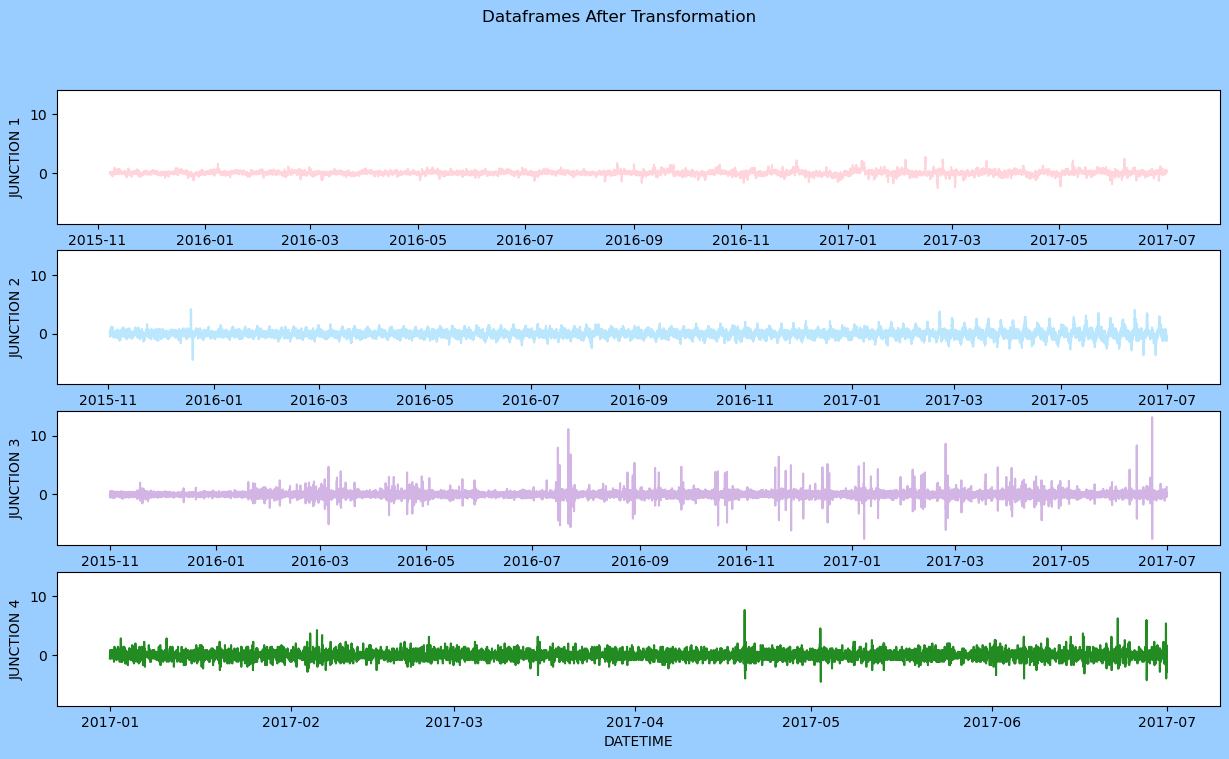

In [59]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

##### The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test.

In [60]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415548
p-value: 4.798539876395171e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940133
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832824
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052266
p-value: 2.7787875325955e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


### Note: The data is stationary, preprocessing the data for the neural net by:

##### Splitting the test train sets
##### Assigning X as features and y as target
##### Reshaping data for neural net

In [61]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Model Building

#### For this project, I have settled to use Gated Recurrent Unit (GRU). In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions.

In [62]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [63]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

# Custom_Model for the prediction
def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(layers.Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))  # Flatten layer
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(CustomLayer(50))  # Custom layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom


#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning.
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The LSTM model 
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The CNN model 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP


#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#99ccff")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Fitting The Model

 #### Fitting the first junction and plotting the predictions and testset

In [64]:
#Predictions For First Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ1_Custom = Custom_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
108/108 [==============================] - 3s 12ms/step - loss: 0.0725 - val_loss: 0.0734
Epoch 2/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0582 - val_loss: 0.0677
Epoch 3/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0541 - val_loss: 0.0639
Epoch 4/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0515 - val_loss: 0.0633
Epoch 5/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0508 - val_loss: 0.0618
Epoch 6/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0507 - val_loss: 0.0616
Epoch 7/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0493 - val_loss: 0.0611
Epoch 8/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0497 - val_loss: 0.0606
Epoch 9/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0480 - val_loss: 0.0595
Epoch 10/50
108/108 [==============================] - 1s 

Epoch 5/50
108/108 [==============================] - 33s 302ms/step - loss: 0.0797 - val_loss: 0.1111
Epoch 6/50
108/108 [==============================] - 32s 300ms/step - loss: 0.0788 - val_loss: 0.1097
Epoch 7/50
108/108 [==============================] - 33s 307ms/step - loss: 0.0789 - val_loss: 0.1146
Epoch 8/50
108/108 [==============================] - 33s 305ms/step - loss: 0.0779 - val_loss: 0.1091
Epoch 9/50
108/108 [==============================] - 33s 302ms/step - loss: 0.0772 - val_loss: 0.1078
Epoch 10/50
108/108 [==============================] - 33s 303ms/step - loss: 0.0768 - val_loss: 0.1087
Epoch 11/50
108/108 [==============================] - 33s 305ms/step - loss: 0.0761 - val_loss: 0.1080
Epoch 12/50
108/108 [==============================] - 33s 303ms/step - loss: 0.0760 - val_loss: 0.1078
Epoch 13/50
108/108 [==============================] - 33s 305ms/step - loss: 0.0754 - val_loss: 0.1073
Epoch 14/50
108/108 [==============================] - 33s 305ms/step

########------Custom Model------########
The root mean squared error is 0.2415651076881797.


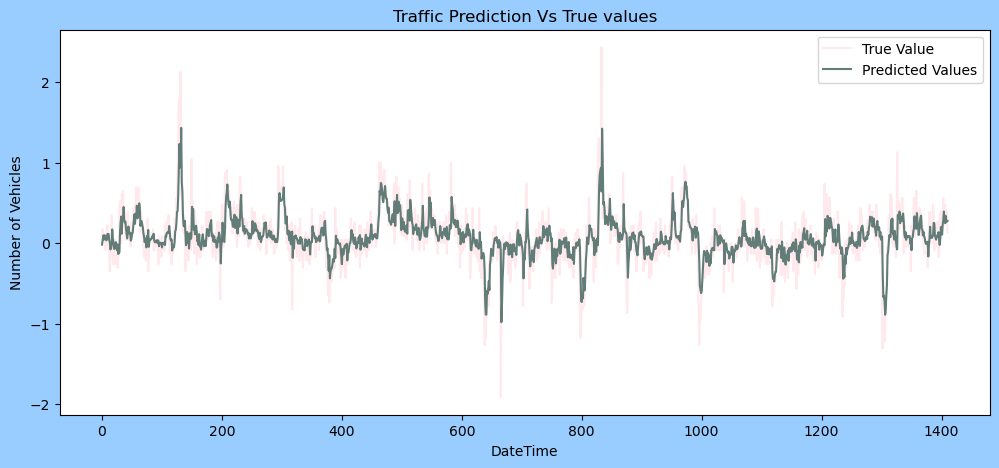

########------GRU Model------########
The root mean squared error is 0.24722599817234586.


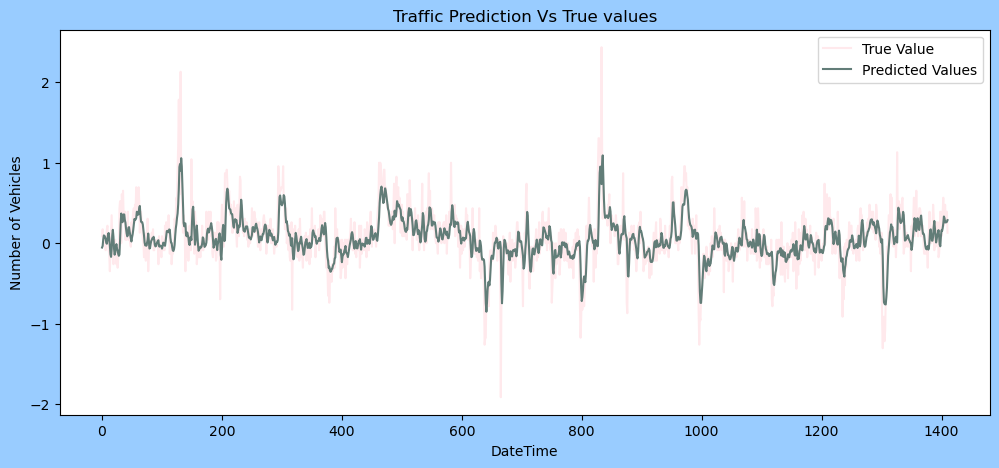


########------LSTM Model------########
The root mean squared error is 0.27220450947129243.


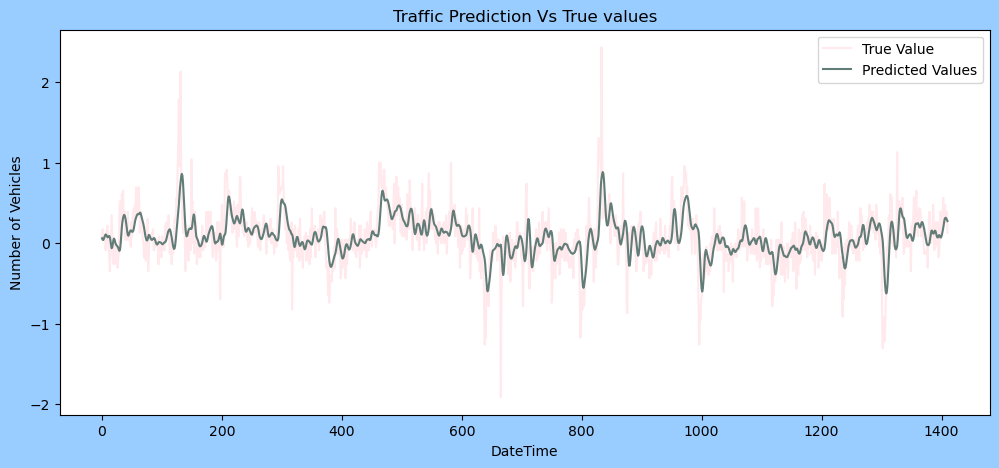


########------CNN Model------########
The root mean squared error is 0.2489504532320074.


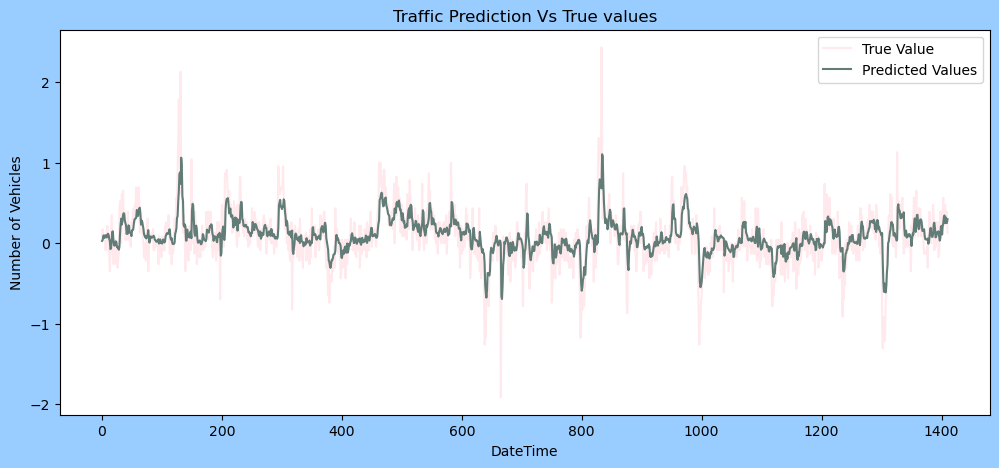


########------MLP Model------########
The root mean squared error is 0.2424487077130379.


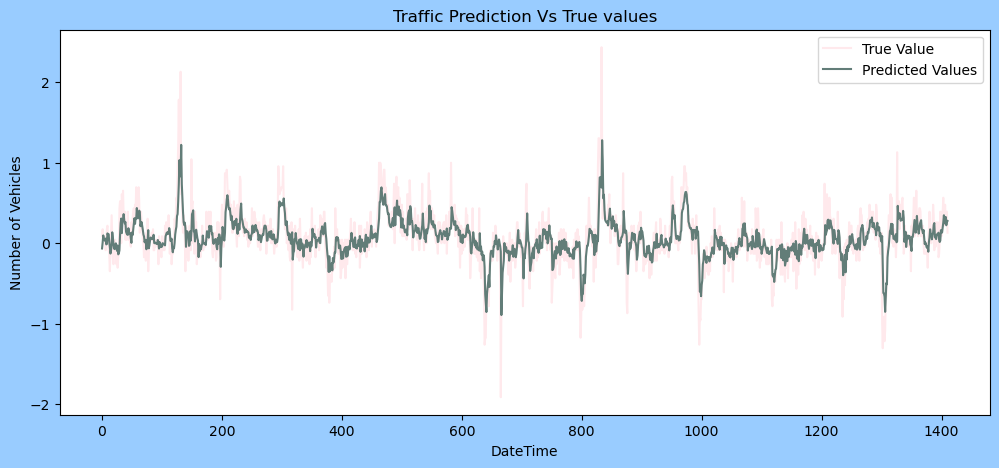


Best Model: Custom - RMSE: 0.2415651076881797



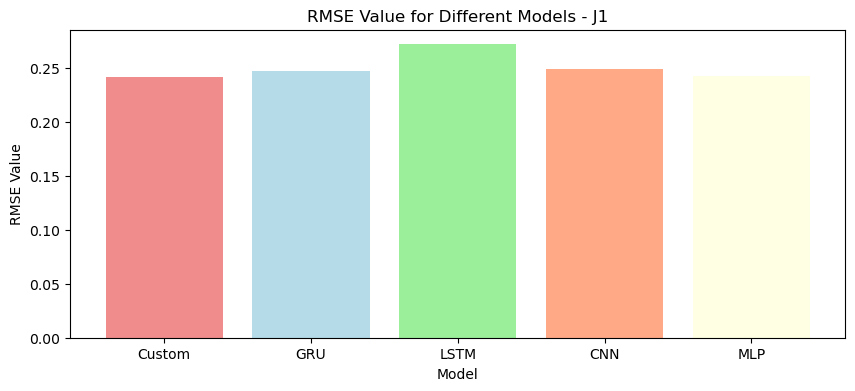

In [65]:
# Results for J1 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

# Results for J1 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)

In [66]:
# Predictions For Second Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
109/109 [==============================] - 2s 9ms/step - loss: 0.2171 - val_loss: 0.3085
Epoch 2/50
109/109 [==============================] - 1s 6ms/step - loss: 0.1716 - val_loss: 0.2698
Epoch 3/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1616 - val_loss: 0.2425
Epoch 4/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1557 - val_loss: 0.2698
Epoch 5/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1504 - val_loss: 0.2303
Epoch 6/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1501 - val_loss: 0.2523
Epoch 7/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1467 - val_loss: 0.2291
Epoch 8/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1444 - val_loss: 0.2428
Epoch 9/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1448 - val_loss: 0.2431
Epoch 10/50
109/109 [==============================] - 1s 5

########------Custom Model------########
The root mean squared error is 0.46919663159191327.


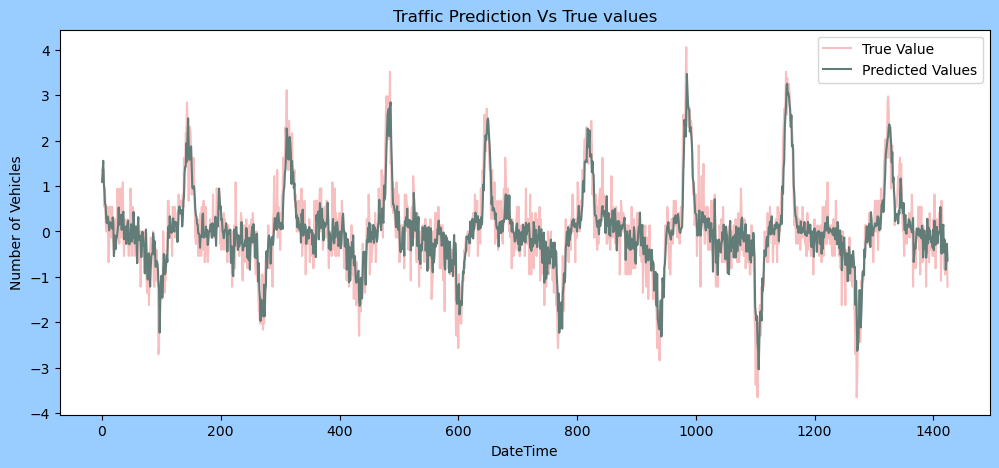

########------GRU Model------########
The root mean squared error is 0.5580548006844347.


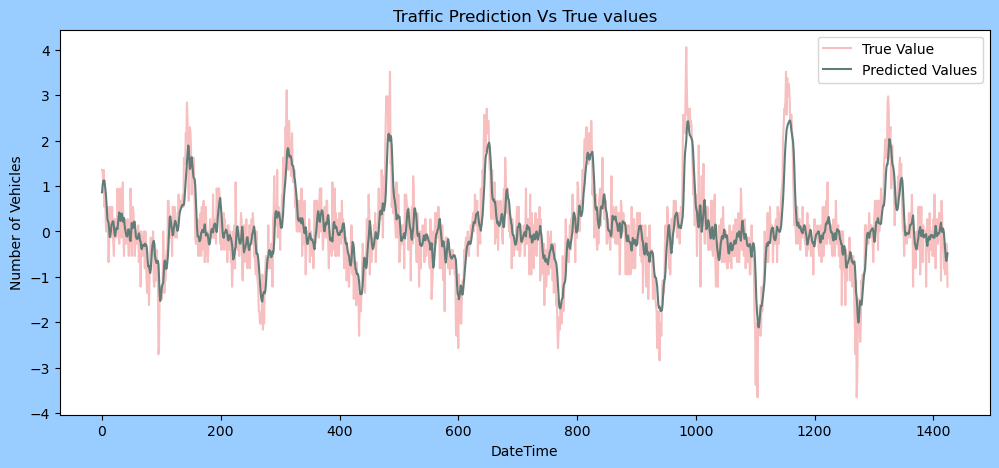


########------LSTM Model------########
The root mean squared error is 0.5752068393085825.


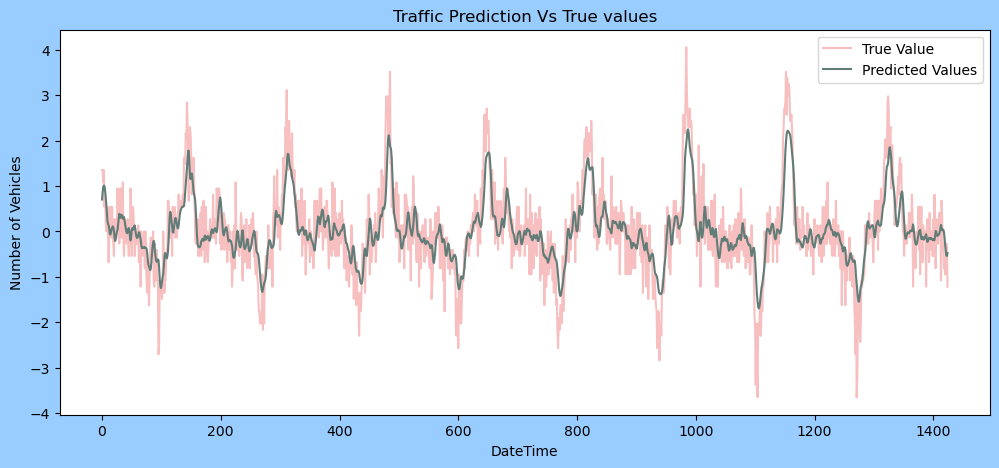


########------CNN Model------########
The root mean squared error is 0.5520336396228793.


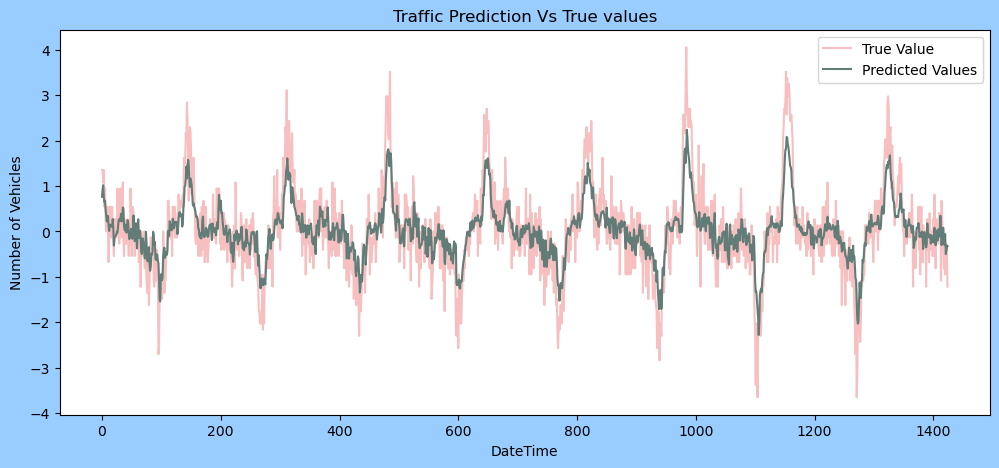


########------MLP Model------########
The root mean squared error is 0.5459195157906604.


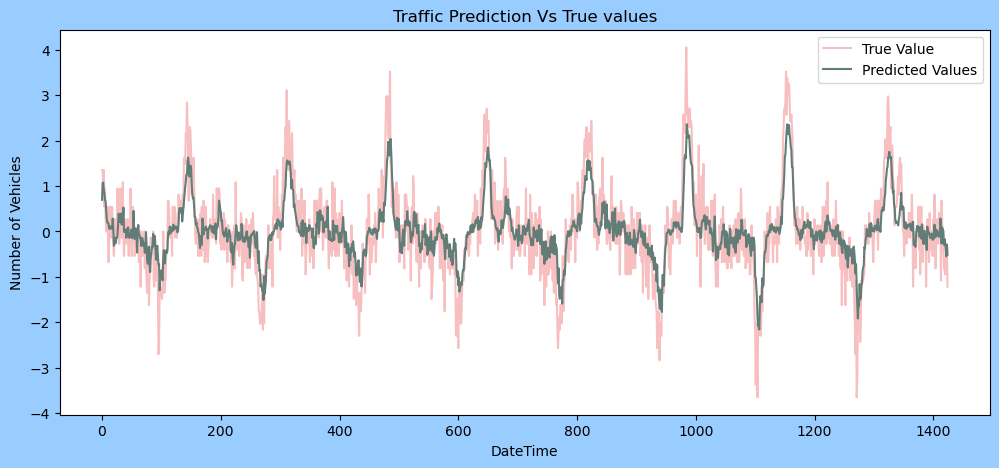


Best Model: Custom - RMSE: 0.46919663159191327



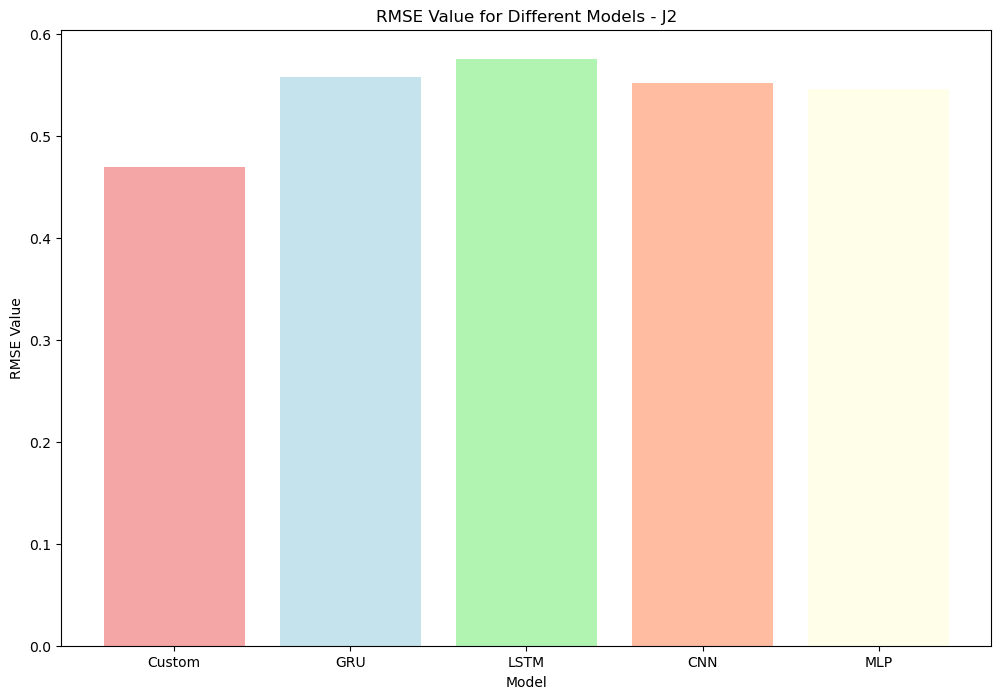

In [67]:
# Results for J2 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)

# Results for J2 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   
# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()
display(styled_df)


In [68]:
# Predictions For Third Junction
# Predictions For Third Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ3_Custom = Custom_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
110/110 [==============================] - 3s 11ms/step - loss: 0.3014 - val_loss: 0.3842
Epoch 2/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2790 - val_loss: 0.3614
Epoch 3/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2666 - val_loss: 0.3468
Epoch 4/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2601 - val_loss: 0.3350
Epoch 5/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2550 - val_loss: 0.3545
Epoch 6/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2530 - val_loss: 0.3435
Epoch 7/50
110/110 [==============================] - 1s 7ms/step - loss: 0.2470 - val_loss: 0.3525
Epoch 8/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2435 - val_loss: 0.3560
Epoch 9/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2417 - val_loss: 0.3519
Epoch 10/50
110/110 [==============================] - 1s 

Epoch 10/50
110/110 [==============================] - 33s 303ms/step - loss: 0.2934 - val_loss: 0.3946
Epoch 11/50
110/110 [==============================] - 34s 311ms/step - loss: 0.2911 - val_loss: 0.3854
Epoch 12/50
110/110 [==============================] - 33s 303ms/step - loss: 0.2918 - val_loss: 0.3849
Epoch 13/50
110/110 [==============================] - 34s 310ms/step - loss: 0.2899 - val_loss: 0.3874
Epoch 14/50
110/110 [==============================] - 33s 303ms/step - loss: 0.2913 - val_loss: 0.3862
Epoch 15/50
110/110 [==============================] - 33s 305ms/step - loss: 0.2906 - val_loss: 0.3875
Epoch 16/50
110/110 [==============================] - 33s 302ms/step - loss: 0.2904 - val_loss: 0.3883
Epoch 17/50
110/110 [==============================] - 33s 301ms/step - loss: 0.2898 - val_loss: 0.3851
Epoch 18/50
110/110 [==============================] - 33s 302ms/step - loss: 0.2901 - val_loss: 0.3848
Epoch 19/50
110/110 [==============================] - 33s 302ms

########------Custom Model------########
The root mean squared error is 0.5650558537187802.


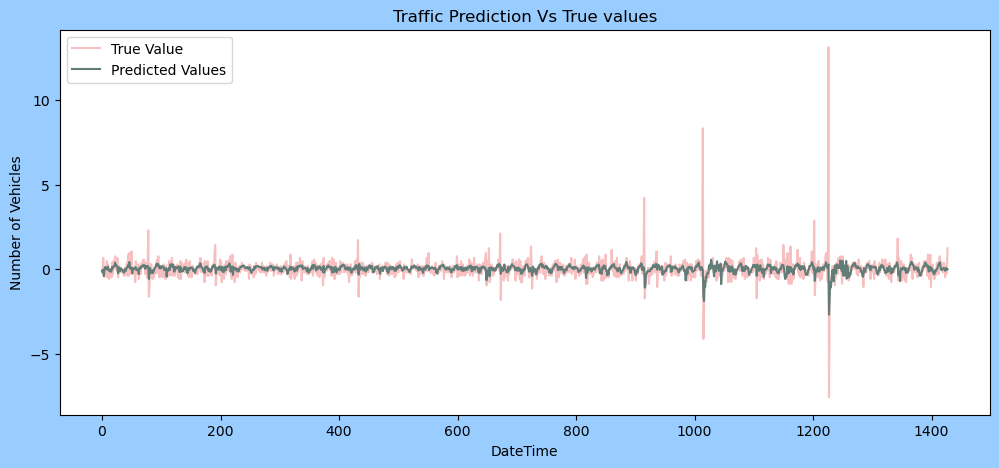

########------GRU Model------########
The root mean squared error is 0.6052717215023355.


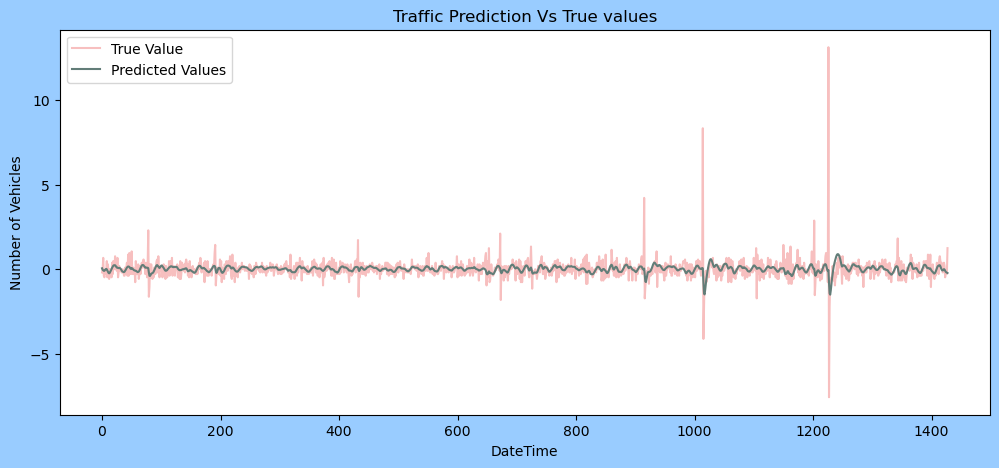


########------LSTM Model------########
The root mean squared error is 0.6207686974148481.


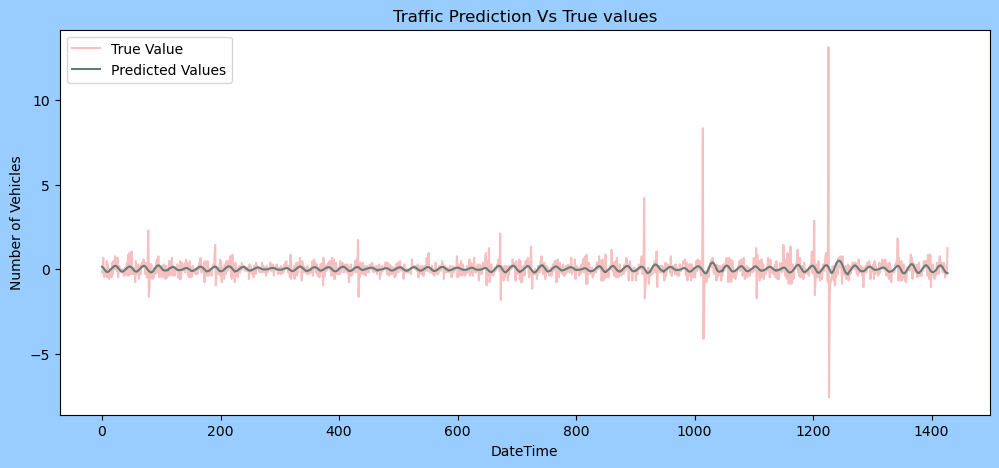


########------CNN Model------########
The root mean squared error is 0.573769802244224.


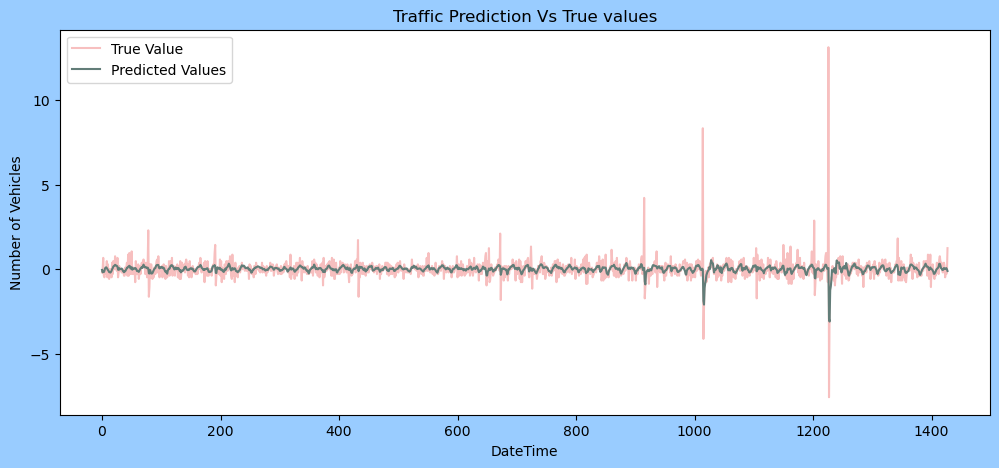


########------MLP Model------########
The root mean squared error is 0.6327116195257856.


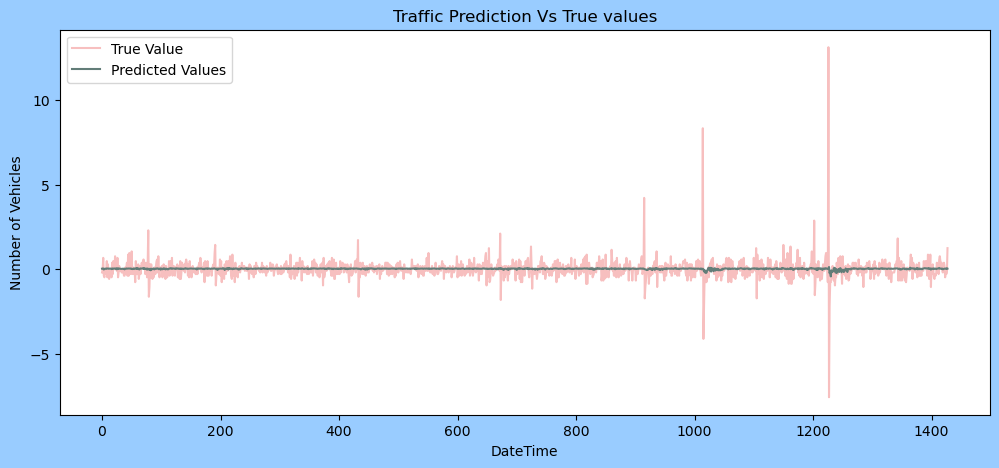


Best Model: Custom - RMSE: 0.5650558537187802



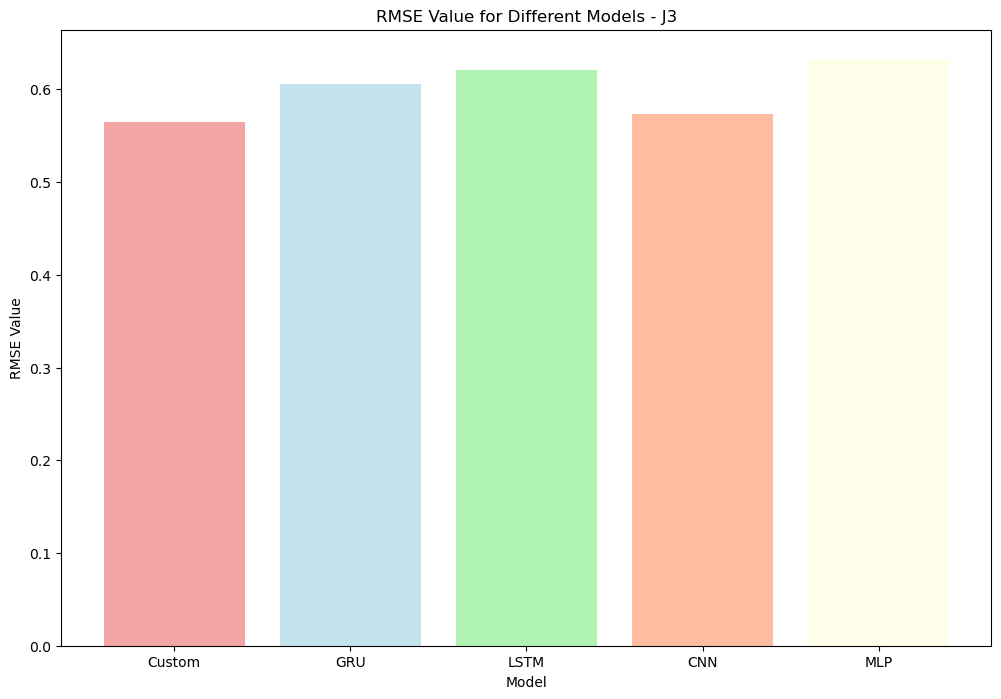

In [69]:
# Results for J3 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J3_Custom = RMSE_Value(y_testJ3, PredJ3_Custom)
PredictionsPlot(y_testJ3, PredJ3_Custom, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)

# Results for J3 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J3_Custom, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN, RMSE_J3_MLP]
model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)

ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [70]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ4_Custom = Custom_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
33/33 [==============================] - 2s 23ms/step - loss: 0.6910 - val_loss: 1.2059
Epoch 2/50
33/33 [==============================] - 0s 8ms/step - loss: 0.6523 - val_loss: 1.1292
Epoch 3/50
33/33 [==============================] - 0s 8ms/step - loss: 0.6050 - val_loss: 1.0780
Epoch 4/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5734 - val_loss: 1.0528
Epoch 5/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5595 - val_loss: 1.0467
Epoch 6/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5394 - val_loss: 1.0307
Epoch 7/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5186 - val_loss: 1.0354
Epoch 8/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5129 - val_loss: 1.0219
Epoch 9/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5105 - val_loss: 1.0215
Epoch 10/50
33/33 [==============================] - 0s 9ms/step - loss: 0.4

Epoch 28/50
33/33 [==============================] - 1s 19ms/step - loss: 0.5025 - val_loss: 1.0286
Epoch 29/50
33/33 [==============================] - 1s 19ms/step - loss: 0.4892 - val_loss: 1.0299
Epoch 30/50
33/33 [==============================] - 1s 19ms/step - loss: 0.4834 - val_loss: 1.0150
Epoch 31/50
33/33 [==============================] - 1s 16ms/step - loss: 0.4850 - val_loss: 1.0163
Epoch 32/50
33/33 [==============================] - 1s 17ms/step - loss: 0.4854 - val_loss: 1.0078
Epoch 33/50
33/33 [==============================] - 1s 17ms/step - loss: 0.4810 - val_loss: 1.0172
Epoch 34/50
33/33 [==============================] - 1s 17ms/step - loss: 0.4766 - val_loss: 1.0139
Epoch 35/50
33/33 [==============================] - 1s 16ms/step - loss: 0.4760 - val_loss: 1.0204
Epoch 36/50
33/33 [==============================] - 1s 17ms/step - loss: 0.4763 - val_loss: 1.0027
Epoch 37/50
33/33 [==============================] - 1s 17ms/step - loss: 0.4826 - val_loss: 1.0057


########------Custom Model------########
The root mean squared error is 1.0015417816887233.


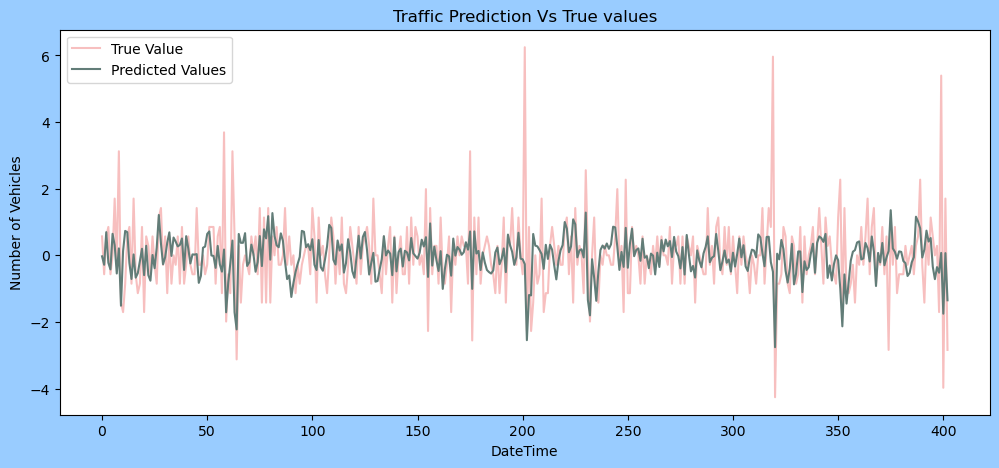

########------GRU Model------########
The root mean squared error is 0.9905580392449179.


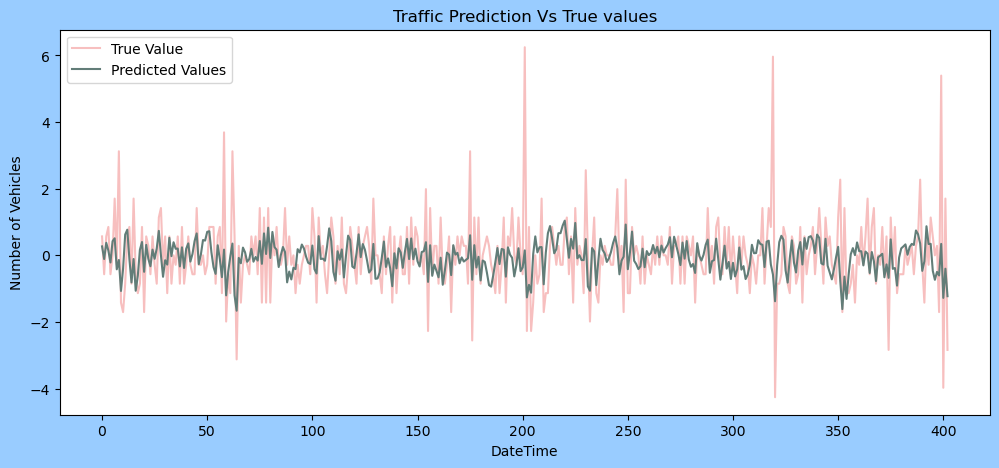


########------LSTM Model------########
The root mean squared error is 1.0969224222395728.


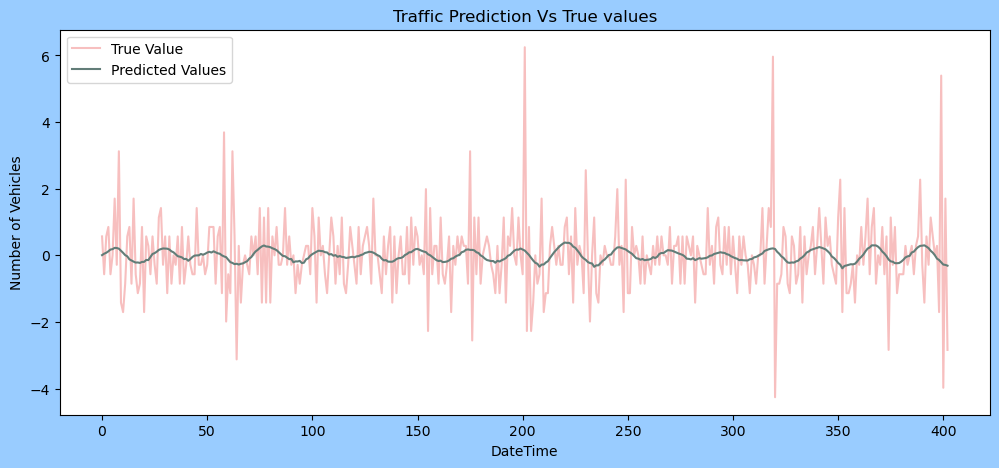


########------CNN Model------########
The root mean squared error is 1.0013252140196578.


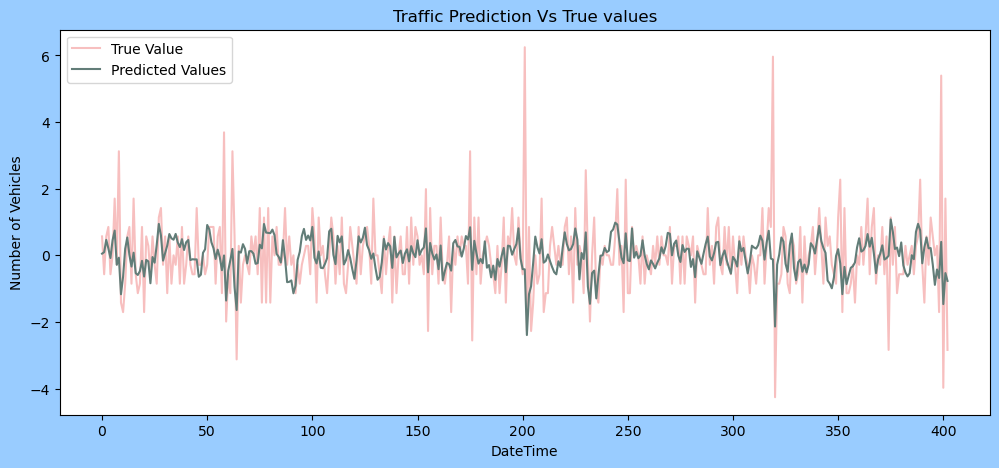


########------MLP Model------########
The root mean squared error is 1.10243510936519.


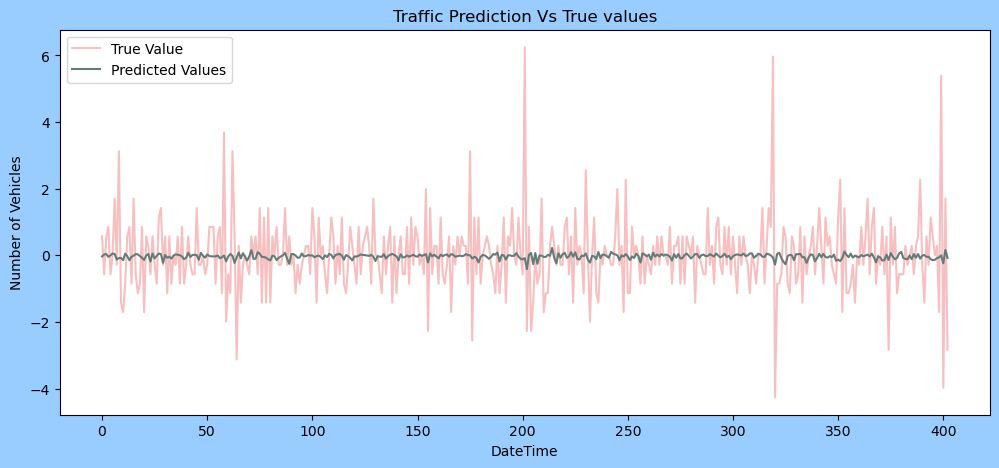


Best Model: GRU - RMSE: 0.9905580392449179



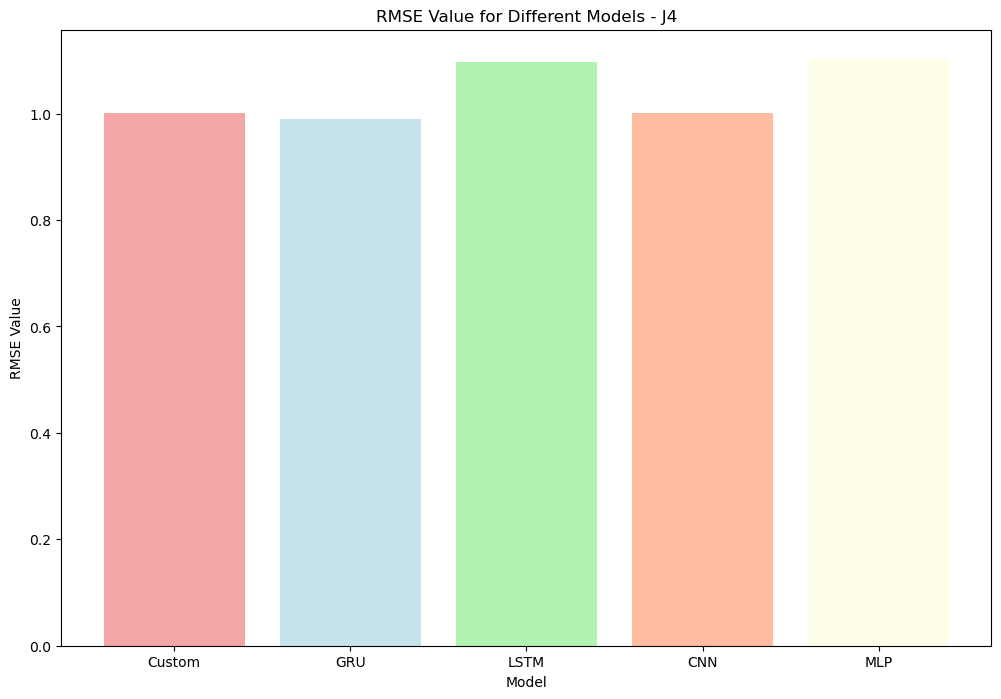

In [71]:
# Results for J4 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J4_Custom = RMSE_Value(y_testJ4, PredJ4_Custom)
PredictionsPlot(y_testJ4, PredJ4_Custom, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)

# Results for J4 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J4_Custom, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]
# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)

# The results of the model

In [72]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))

# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")   

### The Root Mean Square Error is quite a subjective marker for evaluating the performance. Thus, in this project, I am including the outcome plots as well.

## Inversing The Transformation Of Data

#####  I will be inversing transforms that I applied to the datasets to remove the seasonality and trends. Performing this step will make the predictions get back on the accurate scale.

In [75]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast

def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#99ccff")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["VEHICLES"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

## The Inverse Transform on the first junction

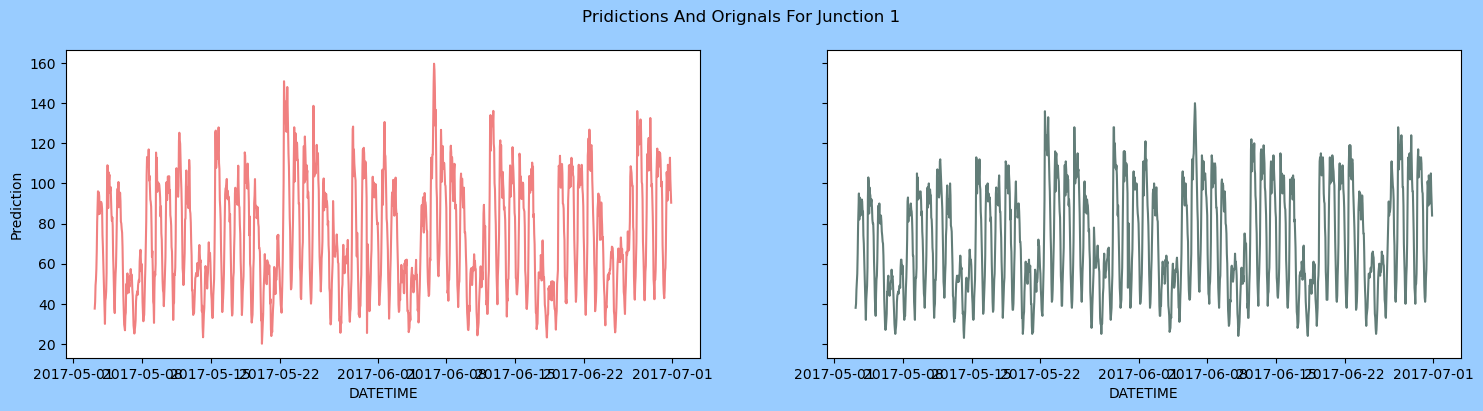

In [76]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= globals()[f"PredJ1_{Model[0]}"]
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]

#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred

#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

## The Inverse Transform on the Second junction

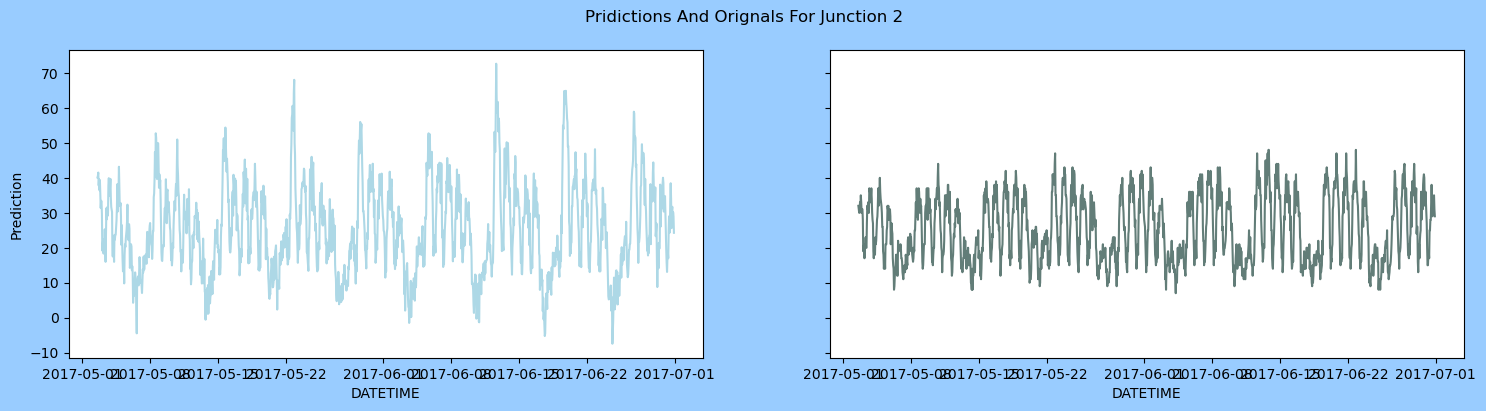

In [77]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= globals()[f"PredJ2_{Model[1]}"]
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred

#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

## The Inverse Transform on the Third junction

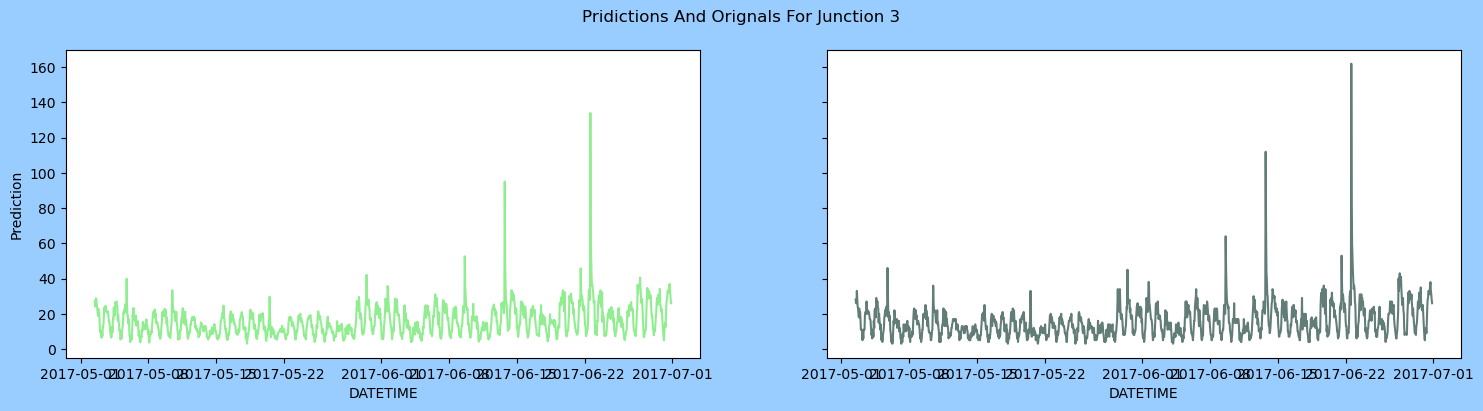

In [78]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= globals()[f"PredJ3_{Model[2]}"]
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]

#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

## The Inverse Transform on the Fourth junction

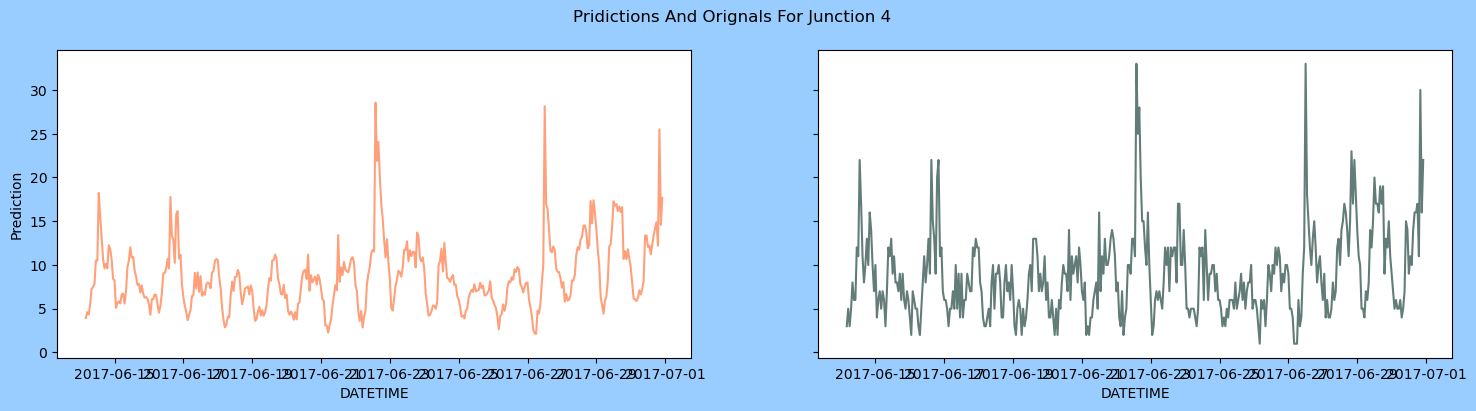

In [79]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= globals()[f"PredJ4_{Model[3]}"]
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]

#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

## Summary

#### In this project, I trained a GRU, CNN, MLP, LSTM and my custom Model to predicted the traffic on four junctions. I used a normalisation and differencing transform to achieve a stationary timeseries.

#### As the Junctions varry in trends and seasonality, I took diffrent approach for each junction to make it stationary. I applyied the root mean squred error as the evaluation metric for the model. In addition to that I plotted the Predictions alongside the original test values. Take aways from the data analysis:

#### The Number of vehicles in Junction one is rising more rapidly compaired to junction two and three. The sparsity of data in juction four bars me from making any conclusion on the same.

#### The Junction one's traffic has a stronger weekly seasonality as well as hourly or mid day to night seasonality. Where as other junctions are significantly linear.